## Importing the dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

## Helper functions

### Helper function to load the dataset:
#### This function helps streamline the data loading with optimal efficiency. It reads the data using pandas, then extracts the features and target labels (X, Y) and finally normalizes the values of the feature data so it lies between 0 and 1 which makes it easier for the DNN to find patterns. The function includes an optional argument of reading the mapping file incase you want to convert the Y labels to their true values. 
#### the function **load_emnist_data()** takes in three arguments as and can be used as follows:
#### **load_emnist_data(**_training_file_path_, _test_file_path_, _mapping_file_path_**)**
#### It then returns a dictionary which includes the **X_train, y_train, X_test, y_test**

In [14]:
def load_emnist_data(train_file, test_file, mapping_file=None):
    """
    Loads the EMNIST dataset from CSV files, splits it into features and labels, 
    and normalizes the feature data. Optionally loads a mapping file that maps 
    labels to characters.
    
    Args:
    - train_file (str): The filepath to the training data CSV file.
    - test_file (str): The filepath to the testing data CSV file.
    - mapping_file (str, optional): The filepath to the mapping file if available.
    
    Returns:
    - dict: A dictionary containing normalized training and testing features and labels,
              and optionally, the mapping data.
    """
    # Load training and testing data from CSV files using pandas.
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    
    # Extracting features (all columns except the first one) and labels (the first column).
    # Convert features to float32 for compatibility with ML models and efficiency.
    X_train = np.array(train_data.iloc[:, 1:], dtype='float32')
    y_train = np.array(train_data.iloc[:, 0])
    X_test = np.array(test_data.iloc[:, 1:], dtype='float32')
    y_test = np.array(test_data.iloc[:, 0])
    
    # Normalize features by dividing by the max value of a pixel (255).
    # This scales all pixel values to be between 0 and 1.
    X_train /= 255.0
    X_test /= 255.0
    
    # Prepare the dictionary to hold data, which ensures easy access and management.
    data_dict = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }
    
    # If a mapping file is provided, read it and add to the dictionary.
    # Mapping file typically contains two columns: label and character representation.
    if mapping_file:
        mapping = pd.read_csv(mapping_file, delim_whitespace=True, header=None, names=['label', 'character'])
        data_dict['mapping'] = mapping
    
    # Return the dictionary containing the dataset.
    return data_dict

### Helper function to translate the mapping file:
#### This function is used as a translator to convert the ascii values for each label in the mapping file to their true value. If no match is found in the mapping file, it reurns a **?** in place of the tru label. The function can be used as follows:
#### **get_character_from_label(**_label_you_want_translated_, _mapping_dataframe_**)**
#### This function correctly translates the given label into its true value.

In [28]:
def get_character_from_label(label, mapping_df):
    """
    Translates a numeric label into the corresponding character using the mapping DataFrame.
    
    This function assumes that the mapping DataFrame contains two columns:
    'label' which is the numeric label, and 'character' which is the ASCII value of the corresponding character.
    
    Args:
    - label (int): The numeric label to translate.
    - mapping_df (pd.DataFrame): The DataFrame containing the mapping information.
    
    Returns:
    - char: The corresponding character as a string, or '?' if the label is not found.
    """
    # Attempt to find the row in the mapping DataFrame where the label matches the input label.
    match = mapping_df.loc[mapping_df['label'] == label, 'character']
    
    if match.empty:
        # If there are no matching rows i.e., the label is not found in the DataFrame, return a placeholder character '?'.
        return '?'
    else:
        # Extract the ASCII value from the DataFrame. 'values[0]' accesses the first element of the result.
        ascii_val = match.values[0]
        # Convert the ASCII value to its corresponding character.
        character = chr(ascii_val)
        return character

### Helper function to visualize the data:
#### This functions streamlines the process of visualizing data by also having other editable parameters. This function inclues the ability to provide a grid of images to visualize based on the users request. by managing the number of images in a grid. It includes the option to provide it with a mapping dataframe to actively translate the label values to their true values.
#### The function can be used as follows:
#### **visualize_data(**_features_, _target_values_, _mapping_dataframe_, _number_of_images_wanted_**)**
#### It returns a grid of images based on the number the user wants.

In [29]:
def visualize_data(X, y, mapping_df=None, num_images=25):
    """
    Visualizes a grid of images with their corresponding character labels.
    
    This function displays a grid of images based on the provided image data and labels. If a mapping
    DataFrame is provided, it will display characters instead of numeric labels.
    
    Args:
    - X (numpy.ndarray): The image data, expected shape is (n_samples, n_features).
    - y (numpy.ndarray): The labels for the images, expected shape is (n_samples,).
    - mapping_df (pd.DataFrame, optional): The DataFrame containing the mapping from labels to characters.
    - num_images (int): Number of images to display in the grid, defaults to 25.
    """
    # Determine the size of the grid based on the number of images.
    num_rows = int(np.sqrt(num_images))
    num_cols = num_rows
    
    # Create a figure with specified dimensions and spacing between subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # Ensuring the fucntion does not exceed the total number of available images.
    actual_images = min(num_images, X.shape[0])  
    
    for i, ax in enumerate(axes.flat):
        if i < actual_images:
            ax.imshow(X[i].reshape([28, 28]))  # Reshape image data for display, assuming images are square (28x28 pixels).
            label = y[i]
            title = f'Label: {label}'

            if mapping_df is not None:
                character = get_character_from_label(y[i], mapping_df)  # Translating numeric label to character using the mapping DataFrame.
                title = f'Label: {character}'
                
            ax.set_title(f'Label: {character}')
            ax.axis('off')  # Hides axis.
        else:
            ax.axis('off')  # Hide axes if there are fewer images than subplots.

### Helper function to visualize the models prediction vs. true label:
#### This function helps the user to print out the required number of samples from the test set and check the model's performance on how well it can predict the images. It compares the true value against the predicted value and visualizes the images for the user. Th user can even provide a mapping file if needed. The function can be used as follows:
#### **visualize_and_predict_top_samples(**_trained_model_, _X_test_data_, _y_test_data_, _mapping_file_, _number_of_samples_wanted_to_check_**)**
#### It the returns the visualization of the number of samples the user wants to check with the actual and predicted label as the title.

In [30]:
def visualize_and_predict_top_samples(model, X_test, y_test, mapping_df=None, num_samples=6):
    """
    Makes predictions for the top samples from the testing dataset using a pre-loaded model,
    and visualizes these samples with their predicted and true labels.
    
    This function visualizes a subset of test samples along with their predicted and true labels,
    which can help in assessing the model's performance visually.
    
    Args:
    - model: Pre-loaded Keras model for prediction.
    - X_test (numpy.ndarray): Testing dataset features, expected shape (num_samples, img_height * img_width).
    - y_test (numpy.ndarray): True labels for the testing dataset, expected shape (num_samples,).
    - mapping_df (pd.DataFrame, optional): Mapping from numeric labels to descriptive labels, if available.
    - num_samples (int): Number of top samples to predict and visualize, defaults to 6.
    """
    # Predict the labels for the specified number of top samples.
    predictions = model.predict(X_test[:num_samples])
    predicted_labels = np.argmax(predictions, axis=1)   # Get the index of the max logit which is the predicted label.

    # Setup the plotting grid.
    num_rows = int(np.ceil(np.sqrt(num_samples)))   # Determine the number of rows in the grid.
    num_cols = int(np.ceil(num_samples / num_rows))   # Determine the number of columns in the grid.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))  # Create a subplot with the calculated grid size.
    fig.subplots_adjust(hspace=1, wspace=0.5)   # Adjust spacing between subplots.

    # Loop through each subplot to visualize each sample.
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(X_test[i].reshape([28, 28]))  # Display the image reshaped to 28x28 pixels.
            true_label = y_test[i]
            predicted_label = predicted_labels[i]

            # If a mapping DataFrame is provided, use it to convert labels to characters.
            if mapping_df is not None:
                true_char = get_character_from_label(true_label, mapping_df)    # Convert true label.
                predicted_char = get_character_from_label(predicted_label, mapping_df)  # Convert predicted label.
                title = f'Pred: {predicted_char}\nTrue: {true_char}'
            else:
                title = f'Pred: {predicted_label}\nTrue: {true_label}'

            ax.set_title(title)
            ax.axis('off')  # Turn off axis.
        else:
            ax.axis('off')  # Turn off unused subplots.

    plt.show()

### Helper function to fix the orientation of the images:
#### As we have seen, the EMNIST images are not correctly oriented. To fix this potential problem, I created a function which helps deal with it. The function fixes the orientation by first roatating the images by 90 degrees clockwise and then flipping them horizontally. The function can be used as follows:
#### **fix_orientation(**_image_data_to_be_fixed_**)**
#### It then return the fixed images.

In [15]:
def fix_orientation(images):
    """
    Fixes the orientation of EMNIST images by rotating 90 degrees clockwise
    and then flipping horizontally. The EMNIST images is stored in a format
    that is not aligned with the standard visual representation, hence this correction
    is necessary for proper visualization and processing.
    
    Args:
    - images (numpy.ndarray): Array of images where each image is flattened.
        Each image should be a flattened array of 784 elements (since 28x28=784).
        
    Returns:
    - numpy.ndarray: Array of images with corrected orientation, flattened back to original dimension.
    """
    # Reshape the flattened image array back to 2D images (28x28).
    # This assumes that all images are 28x28 pixels.
    # Rotate the images 90 degrees clockwise.
    # 'k=-1' means rotate by 90 degrees clockwise.
    # 'axes=(1, 2)' specifies the plane on which to rotate the images.
    images_rotated = np.rot90(images.reshape(-1, 28, 28), k=-1, axes=(1, 2))
    
    # Flip the images horizontally.
    # 'axis=2' indicates that the flipping should happen along the horizontal axis within the image matrix.
    images_corrected = np.flip(images_rotated, axis=2)
    
    # Flatten the images back to their original 1D format.
    # Each 28x28 image is flattened back into a single row of 784 pixels.
    return images_corrected.reshape(-1, 784)

### Helper function for MLP model creation:
#### This function streamlines the model creation for each iteration in the search for best hyperparameters. It takes multiple arguments to help specify the model's parameters. **layer_configs** takes in a list of dictionaries, where each dictionary specifies 1 hidden layer. Each dictionary i.e. layer can be of the form:
#### **{'nodes':** _number_of_nodes_for_that_layer_,
#### **'activation':** _activation_function_,
#### **'dropout':** _dropout_rate_, 
#### **'batch_normalization':** _True/False_,
#### **'l1':** _regularizaton_strength_,
#### **'l2':** _regularizaton_strength_**}**
#### If no regularization or dropout is specified, there will be none for that layer. Any **optimizer** can be specified to compile the model on, the **loss** argument takes the specified loss function to compute the quantity that the model should seek to minimize during training. The **input_shape** takes in the shape of the input data as a tuple and the **num_classes** takes in the number of classes which the output layer has to predict from. The **output_activation** takes in the needed activation function for the output layer and the learning rate can be specified, if none is specified it will use the default value of 0.001.

In [4]:
def create_mlp_model(layer_configs, optimizer, loss, input_shape, num_classes, output_activation, learning_rate=0.001):
    """
    Creates a fully connected multi-layer perceptron (MLP) model based on the provided specifications.
    
    Parameters:
    - layer_configs (list): A list of dictionaries, each specifying the configuration of each layer including the number
                     of nodes, dropout rate, batch normalization, and regularization (L1 or L2).
    - optimizer (str): Name of the optimizer to be used.
    - loss (str): Name of the loss function to be used.
    - input_shape (tuple): Shape of the input data, specifying the number of features, expected shape (img_height * img_width,)
    - num_classes (int): Number of output classes, defining the dimensionality of the output layer.
    - output_activation (str): Activation function for the output layer.
    - learning_rate (float, optional): Learning rate for the optimizer, defaults to 0.001.
    
    Returns:
    - A compiled keras model ready for training.
    """
    # Ensures that we start with a clean slate by clearing any residual model data from previous sessions.
    tf.keras.backend.clear_session()
    
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model = keras.Sequential()
    
    # First layer is explicitly an input layer, setting the shape of the input data.
    model.add(keras.layers.Input(shape=input_shape))
    
    # Loop through each layer configuration and add layers according to specifications.
    for config in layer_configs:
        # Activation defaults to 'relu' if not specified in the configuration.
        activation = config.get('activation', 'relu')
        
        # Add regularization if specified. Supports L1 or L2 based on the configuration provided.
        reg = None
        
        if 'l1' in config:
            reg = keras.regularizers.L1(l1=config.get('l1', 0))
        elif 'l2' in config:
            reg = keras.regularizers.L2(l2=config.get('l2', 0))

        # Add a Dense (fully connected) layer with the specified number of nodes and optional regularization.
        model.add(keras.layers.Dense(config['nodes'], activation=activation, kernel_regularizer=reg))

        # Add Batch Normalization if specified defaults to False if not specified.
        if config.get('batch_normalization', False):
            model.add(keras.layers.BatchNormalization())

        # Add a Dropout layer if specified.
        if 'dropout' in config:
            model.add(keras.layers.Dropout(config['dropout']))
    
    # Add the output layer with the number of classes and specified activation function.
    model.add(keras.layers.Dense(num_classes, activation=output_activation))

    # Map string identifier to actual Keras optimizer objects with the specified learning rate.
    if isinstance(optimizer, str):
        optimizer_dict = {
            'sgd': keras.optimizers.SGD(learning_rate=learning_rate),
            'rmsprop': keras.optimizers.RMSprop(learning_rate=learning_rate),
            'adam': keras.optimizers.Adam(learning_rate=learning_rate),
            'adadelta': keras.optimizers.Adadelta(learning_rate=learning_rate),
            'adagrad': keras.optimizers.Adagrad(learning_rate=learning_rate),
        }
        optimizer = optimizer_dict.get(optimizer.lower())
        if not optimizer:
            # Ensures the provided optimizer is supported, else raise an error.
            # only supports the top 5 optimizers from the keras documentation. Can add more as per requirements.
            raise ValueError(f"Unsupported optimizer {optimizer}. Please pick one from the following: 'sgd', 'rmsprop', 'adam', 'adadelta', 'adagrad'")
            
    # Compiling the model with the specified optimizer, loss function, and evaluation metrics.
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

### Helper function for CNN model creation:
#### Similar to the MLP model creating function, this function streamlines the model creation for each iteration in the search for best hyperparameters. It takes multiple arguments to help specify the model's parameters. **layer_configs** takes in a list of dictionaries, where each dictionary specifies 1 hidden layer. Each dictionary i.e. layer can be of the form:
#### **{'type':** _layer_type_, 
#### **'filters':** _filters_, 
#### **'kernel_size':** _kernel_size_,
#### **'activation':** _activation_function_,
#### **'batch_normalization':** _True/False_,
#### **'l1':** _regularizaton_strength_,
#### **'l2':** _regularizaton_strength_,
#### **'padding':** _padding_,
#### **'pool_size':** _size_of_pooling_layer_,
#### **'nodes':** _nodes_**}**
#### Any **optimizer** can be specified to compile the model on, the **loss** argument takes the specified loss function to compute the quantity that the model should seek to minimize during training. The **input_shape** takes in the shape of the input data as a tuple and the **num_classes** takes in the number of classes which the output layer has to predict from. The **output_activation** takes in the needed activation function for the output layer and the learning rate can be specified, if none is specified it will use the default value of 0.001.

In [121]:
def create_cnn_model(layer_configs, optimizer, loss, input_shape, num_classes, output_activation, learning_rate=0.001):
    """
    Creates a convolutional neural network based on provided specifications.
    
    This function dynamically builds a CNN model by iterating over a list of configurations that specify different
    types of layers, which can include convolutional layers, max pooling, dropout, and dense layers.
    
    Parameters:
    - layer_configs (list): A list of dictionaries, each specifying the configuration of each layer including type 
                            ('conv2d', 'maxpool', 'dropout', 'dense'), and parameters like filters, kernel_size, and activation.
    - optimizer (str): Name of the optimizer to be used.
    - loss (str): Name of the loss function to be used.
    - input_shape (tuple): Shape of the input data, specifying the number of features, expected shape (img_height * img_width,)
    - num_classes (int): Number of output classes, defining the dimensionality of the output layer.
    - output_activation (str): Activation function for the output layer.
    - learning_rate (float, optional): Learning rate for the optimizer if a string is provided for the optimizer.
    
    Returns:
    - A compiled keras model.
    """
    # Ensures that we start with a clean slate by clearing any residual model data from previous sessions.
    tf.keras.backend.clear_session()
    
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model = keras.Sequential()

    # Flag to indicate whether the first convolutional layer has been added.
    first_conv_layer = True
    
    # Process each layer configuration from the list.
    for config in layer_configs:
        # Add a layer with potential regularization, defaults to None if not specified.
        reg = None
        
        if 'l1' in config:
            reg = keras.regularizers.L1(l1=config.get('l1', 0))
        elif 'l2' in config:
            reg = keras.regularizers.L2(l2=config.get('l2', 0))

        # Add Batch Normalization if specified defaults to False if not specified.
        if config.get('batch_normalization', False):
            model.add(keras.layers.BatchNormalization())
        
        # Determine the type of layer to add based on the 'type' key in each configuration dictionary.
        layer_type = config['type'].lower()
        if layer_type == 'conv2d':
            if first_conv_layer:
                # Configure convolutional layers.
                # First conv layer needs to include the input_shape.
                model.add(keras.layers.Conv2D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config.get('activation', 'relu'),
                    padding=config.get('padding', 'same'),
                    kernel_regularizer=reg,
                    input_shape=input_shape
                ))
                # Update the flag so that input_shape is not in the following layers.
                first_conv_layer = False  
            else:
                # Subsequent conv2d layers without input_shape.
                model.add(keras.layers.Conv2D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config.get('activation', 'relu'),
                    padding=config.get('padding', 'same'),
                    kernel_regularizer=reg,
                ))
        elif layer_type == 'maxpool':
            # Add max pooling layer.
            model.add(keras.layers.MaxPooling2D(
                pool_size=config['pool_size']
            ))
        elif layer_type == 'dropout':
            # Add dropout layer for regularization.
            model.add(keras.layers.Dropout(config['rate']))
        elif layer_type == 'flatten':
            # Flatten the output from the convolutional layers to feed into a dense layer.
            model.add(keras.layers.Flatten())
        elif layer_type == 'dense':
            # Add fully connected layers.
            model.add(keras.layers.Dense(
                config['nodes'],
                activation=config.get('activation', 'relu'),
                kernel_regularizer=reg
            ))

    # Add the output layer with the number of classes and specified activation function.
    model.add(keras.layers.Dense(num_classes, activation=output_activation))

    # Map string identifier to actual Keras optimizer objects with the specified learning rate.
    optimizer_dict = {
        'sgd': keras.optimizers.SGD(learning_rate=learning_rate),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=learning_rate),
        'adam': keras.optimizers.Adam(learning_rate=learning_rate),
        'adadelta': keras.optimizers.Adadelta(learning_rate=learning_rate),
        'adagrad': keras.optimizers.Adagrad(learning_rate=learning_rate),
    }
    optimizer = optimizer_dict.get(optimizer.lower())
    if not optimizer:
        # Ensures the provided optimizer is supported, else raise an error.
        # only supports the top 5 optimizers from the keras documentation. Can add more as per requirements.
        raise ValueError(f"Unsupported optimizer {optimizer}. Please pick one from the following: 'sgd', 'rmsprop', 'adam', 'adadelta', 'adagrad'")
    
    # Compiling the model with the specified optimizer, loss function, and evaluation metrics.
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=['accuracy'])
    
    return model

### Helper function for model training:
#### This function streamlines the model training process and even calculates the total time taken for training the model. It includes the use of numerous arguments which help compact number of lines of code into one. If you want to include early stopping in your model, the optional argument for that is present with parameters such as the metric to monitor, the patience, and verbosity. It also includes the use of other parameter which the user can easily specify such as, the number of epochs to train on, the batch size, and also includes the option to pass validation data to check how the model is performing on the validation set. The function can be used as follows:
#### **train_model(**_the_model_to_train_, _X_train_data_, _y_train_data_, _number_of_epochs_, _batch_size_, _tuple_val_data_, _early_stopping_, _metric_to_moitor_for_es_, _patience_, _verbosity_**)**
#### It then returns the trainihng history of the mdoel and the time it took for the model to train.

In [5]:
def train_model(model, X_train, y_train, epochs=10, batch_size=32, validation_data=None,
                early_stopping=False, es_monitor='val_loss', es_patience=5, verbose=1):
    """
    Trains a Keras model using provided training data, with options for validation and early stopping.
    
    Parameters:
    - model: The Keras model to be trained.
    - X_train (numpy.ndarray): Training dataset features, expected shape (num_samples, img_height * img_width).
    - y_train (numpy.ndarray): True labels for the training dataset, expected shape (num_samples,).
    - epochs (int): The number of times to iterate over the entire training dataset.
    - batch_size (int): The number of samples per batch of computation.
    - validation_data (tuple): Data on which to evaluate the loss and any model metrics at the end of each epoch.
                               The model will not be trained on this data. Should be a tuple (X_val, y_val).
    - early_stopping (bool): Flag to enable early stopping, which stops training when a monitored metric has stopped improving.
    - es_monitor (str): The metric to be monitored for early stopping (e.g., 'val_loss').
    - es_patience (int): The number of epochs with no improvement after which training will be stopped.
    - verbose (int): Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

    Returns:
    - history: An object that records training and validation statistics per epoch.
    - train_time: The total time taken to train the model, measured in seconds.
    """
    # Record the start time of the training process.
    start_time = time.time() 

    # Initialize the list of callbacks.
    callbacks = []
    # If early stopping is specified defaults to False.
    if early_stopping:
        # Create an EarlyStopping callback that monitors the specified metric and stops training after a specified patience.
        early_stopping = keras.callbacks.EarlyStopping(monitor=es_monitor, 
                                                       patience=es_patience, 
                                                       verbose=verbose, 
                                                       restore_best_weights=True)   # Restores model weights from the epoch with the best value of the monitored metric.
        if isinstance(early_stopping, keras.callbacks.EarlyStopping):
            callbacks.append(early_stopping)
        else:
            raise TypeError('Failed to create an EarlyStopping callback.')

    # Train the model using the .fit method, which returns a history object containing the training and validation loss and metrics.
    history = model.fit(
        X_train, 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=validation_data,
        callbacks=callbacks if callbacks else None  # Include the list of callbacks, ensuring it's not empty.
    )

    # Record the end time of the training process.
    end_time = time.time()  
    # Calculate the total time taken to train the model.
    train_time = end_time - start_time  

    # Print the training time
    print(f"Training completed in {train_time:.2f} seconds")

    # Return the history of the training and the total training time.
    return history, train_time

### Helper function for model evaluation:
#### Compacts the lines of code for evaluating the performance of the model while giving useful metrics like, accuracy, precision, recall and also plotting the confusion matrix and graphs of accuracy over time and loss over time. This compact function uses the given test data to evaluate the model and geneerate predictions. It the compares those with the true Y values and gets an accuracy score. It then plots the corresponding confusion matrix and classification report which looks at values of precision, recall, and F1 score which can be crucial when checking a model's performance. The line graphs of accuracy and loss over epochs is then plotted, giving a perfect visualization of how the model performs. The function can be used as follows:
#### **evaluate_model(**_model_to_evaluate_, _X_test_data_, _y_test_data, _model_training_history_**)**

In [6]:
def evaluate_model(model, X_test, y_test, history=None):
    """
    Evaluates a model on the test set and plots the results including accuracy,
    confusion matrix, classification report, and accuracy curves.
    
    Parameters:
    - model: Trained keras model to evaluate.
    - X_test (numpy.ndarray): Testing dataset features, expected shape (num_samples, img_height * img_width).
    - y_test (numpy.ndarray): True labels for the testing dataset, expected shape (num_samples,).
    - history: History object from the training session of the model, contains loss and accuracy metrics over epochs.
    """
    # Predict the labels for the test set.
    predictions = model.predict(X_test)
    # Convert probabilities to final class predictions by selecting the class with the highest probability for each instance.
    y_pred = np.argmax(predictions, axis=1)
    
    # Calculate the accuracy of the predictions.
    accuracy = accuracy_score(y_test, y_pred)
    # Print the accuracy as a percentage.
    print(f"Accuracy: {accuracy*100:.2f}%")

    # Generating a confusion matrix.
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Using Seaborn to visualize the confusion matrix as a heatmap.
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()  # Display the confusion matrix.
    
    # Print the classification report, which includes precision, recall, and F1-score for each class.
    print('Classification Report:')
    report = classification_report(y_test, y_pred)
    print(report)
    
    # If a history object is provided, plot the training and validation accuracy and loss over each epoch.
    if history is not None:
        plt.figure(figsize=(12, 6))
        
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()    # Include a legend to identify training vs. validation metrics.

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()    # Include a legend to identify training vs. validation metrics.
        plt.show()  # Display the plots.

### Helper function to run hyperparameter tuning:
#### This fucntions helps with combining all the steps involved in using the Keras Tuner. It eases the usage of the multiple lines of code which can often times be daunting to use. The user can pick between the three options of tuning metods i.e. random search, bayesian optimization, or hyperband. Based on which tuner the user selects, it then creates the appropriate tuner based on the other parameters of the function such as, **create_model_func** which takes in the model function which you have created for the tuner to optimize, the **objective** to monitor, default value is set to 'val_accuracy', **max_trails** to run the tuner for, the **directory** in which you want to store the project in and finally the **project_name** which specifies the name of the project in the directory. after these steps, the tuner is the ran over the number of **epochs** set by the user and the best hyperparameters are then found, printed, and set to the model. The function can be used as follows:
#### **run_hyperparmeter_tuning(**_type_of_tuner_, _model_function_, _X_train_data_, y_train_data_, _X_validation_data_, _y_validation_data_, _objective_to_maximize_, _max_trials_to_run_, _max_epochs_, _overwrite_data_, _directory_to_save_to_, _project_name_**)**

In [10]:
def run_hyperparameter_tuning(tuner_type, create_model_func, X_train, y_train, X_val, y_val,
                              objective='val_accuracy', max_trials=20, max_epochs=10, overwrite=True,
                              directory='tuner_directory', project_name='hyperparam_tuning'):
    """
    Runs hyperparameter tuning using the specified Keras Tuner algorithm.
    
    Args:
    - tuner_type (str): Type of tuner to use ('random', 'bayesian', 'hyperband'), determining the search strategy.
    - create_model_func (callable): Function that builds the Keras model, accepting a HyperParameters instance.
    - X_train (numpy.ndarray): Training dataset features, expected shape (num_samples, img_height * img_width).
    - y_train (numpy.ndarray): True labels for the training dataset, expected shape (num_samples,).
    - X_val (numpy.ndarray): Validation data features, expected shape (num_samples, img_height * img_width).
    - y_val (numpy.ndarray): Validation data labels, expected shape (num_samples,).
    - objective (str): The metric to optimize during tuning (e.g., 'val_accuracy').
    - max_trials (int): The maximum number of different configurations to try.
    - max_epochs (int): The maximum number of epochs to train each model version during hyperparameter search.
    - overwrite (bool): Whether to overwrite the previous project in the same directory.
    - directory (str): The path to the directory where the tuning artifacts will be stored.
    - project_name (str): The name of the project, used to organize tuning artifacts.

    Returns:
    - A trained Keras model with the best found parameters.
    """

    # Initialize the tuner based on the specified type with the appropriate settings.
    if tuner_type.lower() == 'random':
        # Random search explores random configurations.
        tuner = kt.RandomSearch(
            create_model_func,
            objective=objective,
            max_trials=max_trials,
            overwrite=overwrite,
            directory=directory,
            project_name=project_name
        )
    elif tuner_type.lower() == 'bayesian':
        # Bayesian optimization models the performance of past trials to predict future performance.
        tuner = kt.BayesianOptimization(
            create_model_func,
            objective=objective,
            max_trials=max_trials,
            overwrite=overwrite,
            directory=directory,
            project_name=project_name
        )
    elif tuner_type.lower() == 'hyperband':
        # Hyperband uses adaptive resource allocation and early-stopping to converge on a high-performing model.
        tuner = kt.Hyperband(
            create_model_func,
            objective=objective,
            max_epochs=max_epochs,
            overwrite=overwrite,
            directory=directory,
            project_name=project_name
        )
    else:
        # Raise an error if an unsupported tuner type is specified.
        raise ValueError("Unsupported tuner type specified. Choose 'random', 'bayesian', or 'hyperband'.")

    # Start the hyperparameter search process using the training and validation data.
    tuner.search(X_train, y_train, epochs=max_epochs, validation_data=(X_val, y_val))

    # Retrieving the best model and hyperparameters after the search concludes.
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

    # Outputs the best model and its hyperparameters for review.
    print('Best model summary:')
    best_model.summary()
    print('Best hyperparameters:')
    # Displays the best hyperparameters found after the search process.
    for param, value in best_hyperparameters.values.items():
        print(f"{param}: {value}")

    return best_model

## Data preparation

### Loading and understanding the data:
#### The first step is to load the dataset using the functions and understanding the structure of the data. We print out the shape and number of samples in each of the datasets and identify the number of unique classes which will then be used in the output layer with a softmax activation to get a multiclass classification.

In [16]:
data = load_emnist_data('emnist-balanced-train.csv', 'emnist-balanced-test.csv', 'emnist-balanced-mapping.txt')

C:\Users\Acer\AppData\Local\Temp\ipykernel_1804\2929389217.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mapping = pd.read_csv(mapping_file, delim_whitespace=True, header=None, names=['label', 'character'])


In [17]:
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

mapping = data['mapping']

In [18]:
print(f'Training data shape: {X_train.shape}\n'
      f'Testing data shape: {X_test.shape}\n'
      f'Training label data shape: {y_train.shape}\n'
      f'Testing label data shape: {y_test.shape}\n'
      f'Mapping data shape: {mapping.shape}')

Training data shape: (112799, 784)
Testing data shape: (18799, 784)
Training label data shape: (112799,)
Testing label data shape: (18799,)
Mapping data shape: (47, 2)


In [19]:
unique_labels = np.unique(y_train)
num_classes = len(unique_labels)
print(f'Total number of classes: {num_classes}\n'
      f'Unique labels: {unique_labels}')

Total number of classes: 47
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


### Data visualization:
#### Once we have understood the structure of the data, we then move on to visualize it by using the function defined earlier to help with the visualization. In the first visualization we see that the images do not look correct, that i then corrected by fixing the orientation of each image in the dataset using the function and then re-visualizing the corrected images.

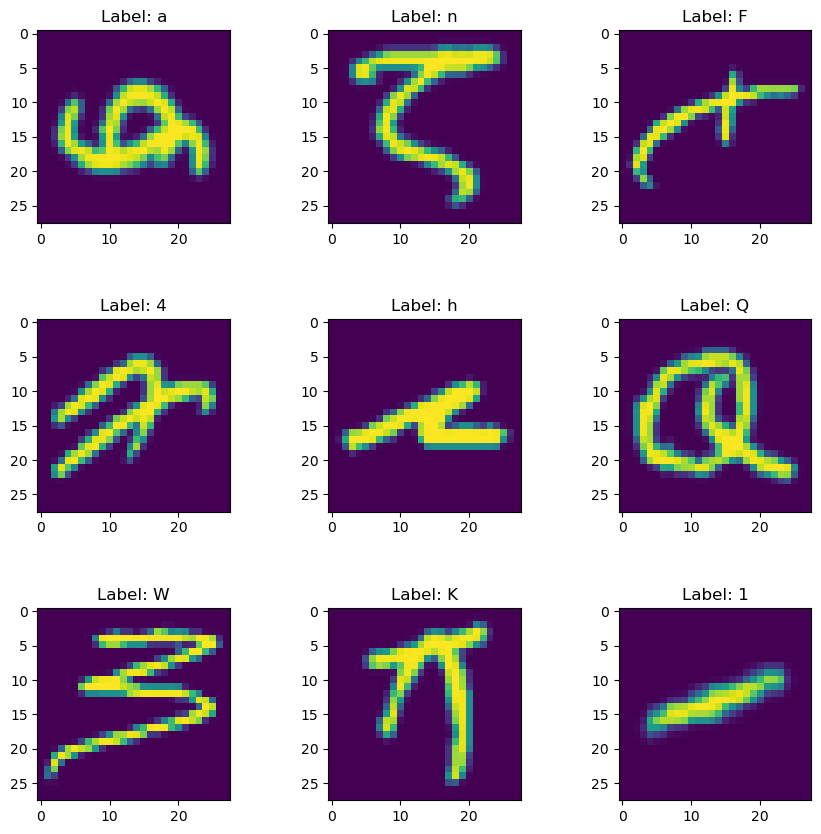

In [15]:
visualize_data(X_train, y_train, mapping, num_images=10)

In [20]:
X_train_corrected = fix_orientation(X_train)
X_test_corrected = fix_orientation(X_test)

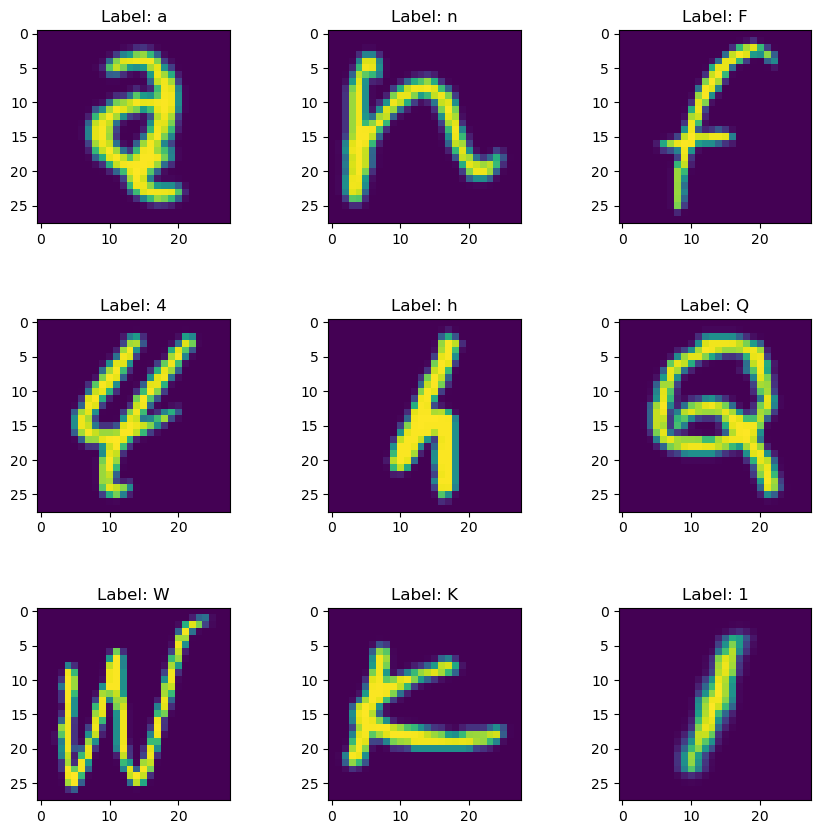

In [17]:
visualize_data(X_train_corrected, y_train, mapping, num_images=10)

### Splitting training and validation set:
#### Once the orientation is fixed, the trainning set is split into a train-validation set where the validation set is 10% of the training set. This is done to check the models performance on the validation data and tune it in case of overfitting/underfitting and hyperparamer tuning. The input size is defined which will then be used in the defination of the input layer of the MLP.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train_corrected, y_train, test_size=0.1, random_state=42)

In [22]:
print(f'Training data shape: {X_train.shape}\n'
      f'Validation data shape: {X_val.shape}\n'
      f'Training label data shape: {y_train.shape}\n'
      f'Validation label data shape: {y_val.shape}')


Training data shape: (101519, 784)
Validation data shape: (11280, 784)
Training label data shape: (101519,)
Validation label data shape: (11280,)


In [23]:
input_size = X_train[0].shape
input_size

(784,)

## MLP
#### Implementation of the multilayer perceptron

### Defining a baseline model:
#### We first start off by defining a baseline model with the minimum requrement of 3 hidden layers. The model creation function is used which was previously defined, making this process clean and easily understandable. The model is trained for 10 epochs with a batch size of 32. 
#### Baseline Accuracy: 69.45%

In [21]:
configs = [
    {'nodes': 512}, # 1st layer
    {'nodes': 1024}, # 2nd layer
    {'nodes': 1024} # 3rd layer
]

baseline_model = create_mlp_model(layer_configs=configs, 
                                  optimizer='sgd', 
                                  loss='sparse_categorical_crossentropy', 
                                  input_shape=input_size, 
                                  num_classes=num_classes, 
                                  output_activation='softmax')

In [22]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 47)                48175     
                                                                 
Total params: 2,025,007
Trainable params: 2,025,007
Non-trainable params: 0
_________________________________________________________________


In [23]:
baseline_model_history, baseline_model_time = train_model(baseline_model, X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
3173/3173 [==============================] - 14s 4ms/step - loss: 3.6281 - accuracy: 0.1864 - val_loss: 3.2673 - val_accuracy: 0.3875
Epoch 2/10
3173/3173 [==============================] - 12s 4ms/step - loss: 2.6385 - accuracy: 0.4618 - val_loss: 2.0328 - val_accuracy: 0.5299
Epoch 3/10
3173/3173 [==============================] - 12s 4ms/step - loss: 1.7517 - accuracy: 0.5599 - val_loss: 1.5498 - val_accuracy: 0.5846
Epoch 4/10
3173/3173 [==============================] - 12s 4ms/step - loss: 1.4617 - accuracy: 0.6028 - val_loss: 1.3823 - val_accuracy: 0.6199
Epoch 5/10
3173/3173 [==============================] - 12s 4ms/step - loss: 1.3353 - accuracy: 0.6305 - val_loss: 1.2863 - val_accuracy: 0.6473
Epoch 6/10
3173/3173 [==============================] - 12s 4ms/step - loss: 1.2556 - accuracy: 0.6508 - val_loss: 1.2205 - val_accuracy: 0.6660
Epoch 7/10
3173/3173 [==============================] - 12s 4ms/step - loss: 1.1964 - accuracy: 0.6660 - val_loss: 1.1731 - val_ac

588/588 [==============================] - 1s 2ms/step
Accuracy: 69.45%


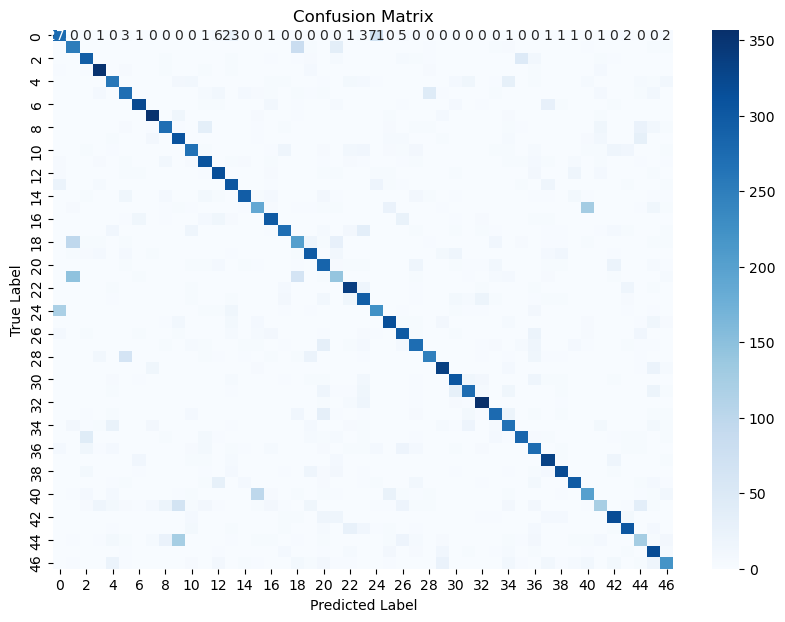

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       400
           1       0.48      0.63      0.54       400
           2       0.73      0.73      0.73       400
           3       0.83      0.88      0.86       400
           4       0.67      0.65      0.66       400
           5       0.67      0.68      0.67       400
           6       0.86      0.81      0.83       400
           7       0.85      0.88      0.87       400
           8       0.74      0.68      0.71       400
           9       0.56      0.77      0.65       400
          10       0.72      0.67      0.69       400
          11       0.71      0.77      0.74       400
          12       0.74      0.79      0.77       400
          13       0.72      0.76      0.74       400
          14       0.87      0.74      0.80       400
          15       0.54      0.47      0.50       400
          16       0.77      0.75      0.76       400
    

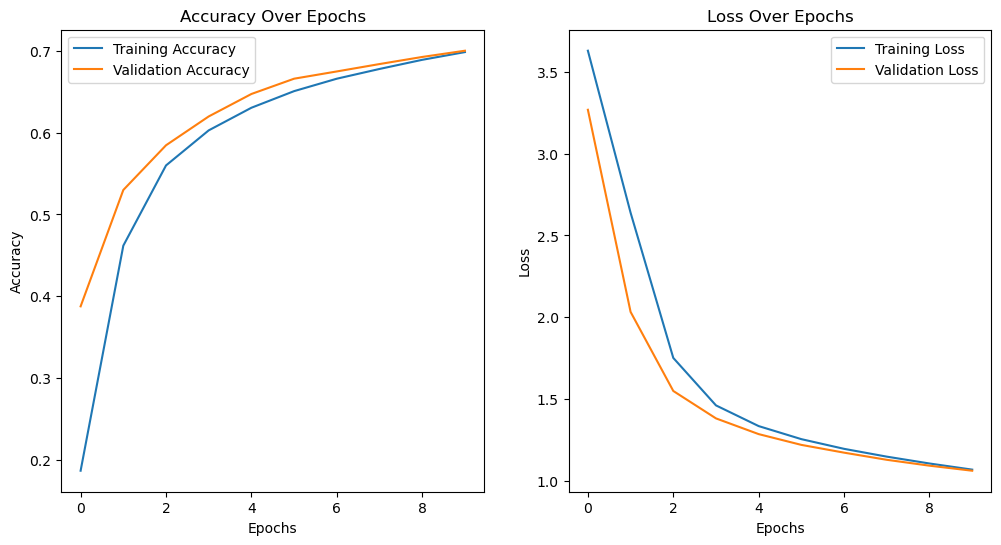

In [24]:
evaluate_model(baseline_model, X_test_corrected, y_test, history=baseline_model_history)

### Model 2 - Optimizer search:
#### In the second model we move on to using the baseline configuration of the model and finding the most suitable optimizer using the random search algorithm of the Keras Tuner.
#### Optimizers searched: Adam, SGD, RMSprop
#### Best optimizer: Adam

In [27]:
configs = [
    {'nodes': 512}, # 1st layer
    {'nodes': 1024}, # 2nd layer
    {'nodes': 1024} # 3rd layer
]

# Function that creates a Keras model with hp as the argument to use the Keras Tuner for hyperparameter search
def build_model(hp):
    # Testing between three optimizers
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    
    model_2 = create_mlp_model(layer_configs=configs, 
                               optimizer=optimizer, 
                               loss='sparse_categorical_crossentropy', 
                               input_shape=input_size, 
                               num_classes=num_classes, 
                               output_activation='softmax')
    return model_2

In [28]:
model_2 = run_hyperparameter_tuning('random', build_model, X_train, y_train, X_val, y_val, 
                                    objective='val_accuracy', max_trials=5, max_epochs=5, directory='tuner', project_name='optimizer')

Trial 3 Complete [00h 01m 02s]
val_accuracy: 0.6417553424835205

Best val_accuracy So Far: 0.8370567560195923
Total elapsed time: 00h 03m 27s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 47)                48175     
                                                                 
Total params: 2,025,007
Trainable params: 2,025,007
Non-trainable params: 0
_________________________________________________________________
Best hyperparame

### Model 3 - Learning Rate search:
#### In the third model we move on to using the baseline configuration of the model along with the best found optimizer from the previous step and finding the most suitable learning rate using the Bayesian algorithm of the Keras Tuner.
#### Range of learning rates searched: [0.00001, 1]
#### Best learning rate: 0.0001

In [29]:
configs = [
    {'nodes': 512}, # 1st layer
    {'nodes': 1024}, # 2nd layer
    {'nodes': 1024} # 3rd layer
]

def build_model(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1, step=10, sampling="log")

    model_3 = create_mlp_model(layer_configs=configs, 
                               optimizer='adam', 
                               loss='sparse_categorical_crossentropy', 
                               input_shape=input_size, 
                               num_classes=num_classes, 
                               output_activation='softmax',
                               learning_rate=learning_rate)
    return model_3

In [30]:
model_3 = run_hyperparameter_tuning('bayesian', build_model, X_train, y_train, X_val, y_val, 
                                    objective='val_accuracy', max_trials=5, max_epochs=5, directory='tuner', project_name='learning_rate')

Trial 5 Complete [00h 01m 03s]
val_accuracy: 0.7458333373069763

Best val_accuracy So Far: 0.8460106253623962
Total elapsed time: 00h 05m 23s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 47)                48175     
                                                                 
Total params: 2,025,007
Trainable params: 2,025,007
Non-trainable params: 0
_________________________________________________________________
Best hyperparame

### Model 4 - Learning rate scheduling (Exponential Decay):
#### We now test out 2 different learning rate schedulers. In this first test we use the Exponential decay which uses the initial learning rate as the best one found in the previous step. It then decays every 10000 samples with a decay rate of 0.9 which was found to be the best after researching and trying out different values.

In [31]:
configs = [
    {'nodes': 512}, # 1st layer
    {'nodes': 1024}, # 2nd layer
    {'nodes': 1024} # 3rd layer
]

exp_dcy = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, 
                                                      decay_steps=10000, 
                                                      decay_rate=0.9)

model_4 = create_mlp_model(layer_configs=configs, 
                           optimizer='adam', 
                           loss='sparse_categorical_crossentropy', 
                           input_shape=input_size, 
                           num_classes=num_classes, 
                           output_activation='softmax',
                           learning_rate=exp_dcy)

In [32]:
model_4_history, model_4_time = train_model(model_4, X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
3173/3173 [==============================] - 13s 4ms/step - loss: 1.0625 - accuracy: 0.6925 - val_loss: 0.7097 - val_accuracy: 0.7751
Epoch 2/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.5927 - accuracy: 0.8083 - val_loss: 0.5534 - val_accuracy: 0.8186
Epoch 3/10
3173/3173 [==============================] - 12s 4ms/step - loss: 0.4837 - accuracy: 0.8381 - val_loss: 0.5142 - val_accuracy: 0.8302
Epoch 4/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.4181 - accuracy: 0.8574 - val_loss: 0.4727 - val_accuracy: 0.8372
Epoch 5/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.3734 - accuracy: 0.8681 - val_loss: 0.4537 - val_accuracy: 0.8426
Epoch 6/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.3369 - accuracy: 0.8804 - val_loss: 0.4393 - val_accuracy: 0.8514
Epoch 7/10
3173/3173 [==============================] - 12s 4ms/step - loss: 0.3074 - accuracy: 0.8889 - val_loss: 0.4356 - val_ac

### Model 5 - Learning rate scheduling (Inverse Time Decay):
#### In this second test we use the INverse Time decay which uses the initial learning rate as the best one found in the previous step. It then decays every 10000 samples with a decay rate of 0.9 which was found to be the best after researching and trying out different values. This was found to be the best performing scheduler as it produces a higher accuracy.

In [33]:
configs = [
    {'nodes': 512}, # 1st layer
    {'nodes': 1024}, # 2nd layer
    {'nodes': 1024} # 3rd layer
]

inv_dcy = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=0.001, 
                                                      decay_steps=10000, 
                                                      decay_rate=0.9)

model_5 = create_mlp_model(layer_configs=configs, 
                           optimizer='adam', 
                           loss='sparse_categorical_crossentropy', 
                           input_shape=input_size, 
                           num_classes=num_classes, 
                           output_activation='softmax',
                           learning_rate=inv_dcy)

In [34]:
model_5_history, model_5_time = train_model(model_5, X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.7857 - accuracy: 0.7485 - val_loss: 0.5554 - val_accuracy: 0.8119
Epoch 2/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.4706 - accuracy: 0.8364 - val_loss: 0.4618 - val_accuracy: 0.8426
Epoch 3/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.3725 - accuracy: 0.8647 - val_loss: 0.4427 - val_accuracy: 0.8488
Epoch 4/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.3050 - accuracy: 0.8833 - val_loss: 0.4464 - val_accuracy: 0.8494
Epoch 5/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.2534 - accuracy: 0.9000 - val_loss: 0.4503 - val_accuracy: 0.8582
Epoch 6/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.2140 - accuracy: 0.9118 - val_loss: 0.4587 - val_accuracy: 0.8588
Epoch 7/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.1806 - accuracy: 0.9249 - val_loss: 0.5037 - val_ac

### Model 6 - Batch size (16):
#### This part involves the exploration of different batch sizes. Using a batch size of 16, proves to take a longer time to train as compared to the previous batch size of 32, while improving the accuracy a little.

In [51]:
configs = [
    {'nodes': 512}, # 1st layer
    {'nodes': 1024}, # 2nd layer
    {'nodes': 1024} # 3rd layer
]

model_6 = create_mlp_model(layer_configs=configs, 
                           optimizer='adam', 
                           loss='sparse_categorical_crossentropy', 
                           input_shape=input_size, 
                           num_classes=num_classes, 
                           output_activation='softmax',
                           learning_rate=inv_dcy)

In [52]:
model_6_history, model_6_time = train_model(model_6, X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/10
6345/6345 [==============================] - 24s 4ms/step - loss: 0.7925 - accuracy: 0.7462 - val_loss: 0.5571 - val_accuracy: 0.8145
Epoch 2/10
6345/6345 [==============================] - 24s 4ms/step - loss: 0.4633 - accuracy: 0.8380 - val_loss: 0.4832 - val_accuracy: 0.8377
Epoch 3/10
6345/6345 [==============================] - 25s 4ms/step - loss: 0.3584 - accuracy: 0.8688 - val_loss: 0.4386 - val_accuracy: 0.8517
Epoch 4/10
6345/6345 [==============================] - 24s 4ms/step - loss: 0.2885 - accuracy: 0.8895 - val_loss: 0.4628 - val_accuracy: 0.8532
Epoch 5/10
6345/6345 [==============================] - 24s 4ms/step - loss: 0.2358 - accuracy: 0.9057 - val_loss: 0.4869 - val_accuracy: 0.8560
Epoch 6/10
6345/6345 [==============================] - 25s 4ms/step - loss: 0.1963 - accuracy: 0.9194 - val_loss: 0.5235 - val_accuracy: 0.8575
Epoch 7/10
6345/6345 [==============================] - 24s 4ms/step - loss: 0.1657 - accuracy: 0.9306 - val_loss: 0.5505 - val_ac

### Model 7 - Batch size (64):
#### This uses a batch size of 64, which takes much less time to train, but decreases the accuracy a bit. Staying with a batch size of 32 seemed to be the best as its in the middle of these batches and gives a good accuracy.

In [53]:
configs = [
    {'nodes': 512}, # 1st layer
    {'nodes': 1024}, # 2nd layer
    {'nodes': 1024} # 3rd layer
]

model_7 = create_mlp_model(layer_configs=configs, 
                           optimizer='adam', 
                           loss='sparse_categorical_crossentropy', 
                           input_shape=input_size, 
                           num_classes=num_classes, 
                           output_activation='softmax',
                           learning_rate=inv_dcy)

In [54]:
model_7_history, model_7_time = train_model(model_7, X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
1587/1587 [==============================] - 7s 4ms/step - loss: 0.7896 - accuracy: 0.7476 - val_loss: 0.5421 - val_accuracy: 0.8184
Epoch 2/10
1587/1587 [==============================] - 6s 4ms/step - loss: 0.4735 - accuracy: 0.8354 - val_loss: 0.4853 - val_accuracy: 0.8326
Epoch 3/10
1587/1587 [==============================] - 6s 4ms/step - loss: 0.3801 - accuracy: 0.8628 - val_loss: 0.4553 - val_accuracy: 0.8457
Epoch 4/10
1587/1587 [==============================] - 6s 4ms/step - loss: 0.3163 - accuracy: 0.8807 - val_loss: 0.4545 - val_accuracy: 0.8448
Epoch 5/10
1587/1587 [==============================] - 6s 4ms/step - loss: 0.2709 - accuracy: 0.8946 - val_loss: 0.4373 - val_accuracy: 0.8555
Epoch 6/10
1587/1587 [==============================] - 6s 4ms/step - loss: 0.2287 - accuracy: 0.9081 - val_loss: 0.4544 - val_accuracy: 0.8594
Epoch 7/10
1587/1587 [==============================] - 6s 4ms/step - loss: 0.2004 - accuracy: 0.9177 - val_loss: 0.4758 - val_accuracy:

### Model 8 - Layers/nodes:
#### Moving on to finding the ideal number of layers and nodes per layer, We built a function for the Keras Tuner passing hp as the parameter. The function loops through adding 3 - 5 layers and the nodes in each of these layers between 64 and 512 with a step size of 64. This can be changed to look for more layers and more nodes, but would be computationally expensive. Using the Bayesian algorithm for this helps as it uses the Gaussian process which is more efficient than random search as it looks for new itteration around the best performing combination.

In [55]:
def build_model(hp):
    # Ensures that we start with a clean slate by clearing any residual model data from previous sessions.
    tf.keras.backend.clear_session()
    
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model = keras.Sequential()
    
    # First layer is explicitly an input layer, setting the shape of the input data.
    model.add(keras.layers.Input(shape=input_size))
    
   # Dynamically adding layers and cycling through nodes in each of them.
    for i in range(hp.Int('num_layers', 3, 5)):
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), min_value=64, max_value=512, step=64),  # Each layer can have a minimum number of 64 or a maximum of 512 nodes and can increase/decrease by 64 every iteration.
            activation='relu'
        ))  
    
    # Add the output layer with the number of classes and softmax activation function.
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
            
    # Compiling the model with the Adam optimizer, loss function, and accuracy as the evaluation metric.
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=inv_dcy),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [56]:
model_8 = run_hyperparameter_tuning('bayesian', build_model, X_train, y_train, X_val, y_val, 
                                    objective='val_accuracy', max_trials=15, max_epochs=5, directory='tuner', project_name='layers_nodes')

Trial 15 Complete [00h 01m 06s]
val_accuracy: 0.8431737422943115

Best val_accuracy So Far: 0.8500000238418579
Total elapsed time: 00h 17m 15s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               150720    
                                                                 
 dense_1 (Dense)             (None, 320)               61760     
                                                                 
 dense_2 (Dense)             (None, 320)               102720    
                                                                 
 dense_3 (Dense)             (None, 47)                15087     
                                                                 
Total params: 330,287
Trainable params: 330,287
Non-trainable params: 0
_________________________________________________________________
Best hyperparameter

### Model 9 - Activation function:
#### We now find the best activation function using the previously found best layers and nodes.
#### Activation functions searched: relu, elu, leaky relu
#### Best activation function: relu

In [58]:
def build_model(hp):
    # Testing between 3 activation functions
    activation=hp.Choice('activation', values=['relu', 'elu', 'leaky_relu'])
    
    configs = [
    {'nodes': 192, 'activation': activation}, # 1st layer
    {'nodes': 320, 'activation': activation}, # 2nd layer
    {'nodes': 320, 'activation': activation}] # 3rd layer


    model_9 = create_mlp_model(layer_configs=configs, 
                               optimizer='adam', 
                               loss='sparse_categorical_crossentropy', 
                               input_shape=input_size, 
                               num_classes=num_classes, 
                               output_activation='softmax',
                               learning_rate=inv_dcy)
    return model_9

In [59]:
model_9 = run_hyperparameter_tuning('random', build_model, X_train, y_train, X_val, y_val, 
                                    objective='val_accuracy', max_trials=5, max_epochs=5, directory='tuner', project_name='activation')

Trial 3 Complete [00h 01m 02s]
val_accuracy: 0.8479610085487366

Best val_accuracy So Far: 0.8479610085487366
Total elapsed time: 00h 03m 08s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               150720    
                                                                 
 dense_1 (Dense)             (None, 320)               61760     
                                                                 
 dense_2 (Dense)             (None, 320)               102720    
                                                                 
 dense_3 (Dense)             (None, 47)                15087     
                                                                 
Total params: 330,287
Trainable params: 330,287
Non-trainable params: 0
_________________________________________________________________
Best hyperparameters

### Model 10 - Batch normalization:
#### We test for each combination of adding a batch normalization layer in the model configs. This process is done by again defining the build model function for the kears tuner. and using the boolean function of deciding when to activate the batch norm layer.

In [60]:
def build_model(hp):
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model = keras.Sequential()
    
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model.add(keras.layers.InputLayer(input_shape=input_size))

    configs = [
        {'nodes': 192, 'activation': 'relu'}, # 1st layer
        {'nodes': 320, 'activation': 'relu'}, # 2nd layer
        {'nodes': 320, 'activation': 'relu'} # 3rd layer
    ]

    for i, config in enumerate(configs):
        # Add a Dense layer as defined in the config.
        model.add(keras.layers.Dense(
            units=config['nodes'],
            activation=config['activation']
        ))

        # Dynamically decide to add Batch Normalization based on the tuner's decision.
        if hp.Boolean(f'batch_norm_layer_{i}'):
            model.add(keras.layers.BatchNormalization())

    # Add the output layer with the number of classes and softmax activation function.
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    # Compiling the model with the Adam optimizer, loss function, and accuracy as the evaluation metric.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=inv_dcy),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [61]:
model_10 = run_hyperparameter_tuning('bayesian', build_model, X_train, y_train, X_val, y_val, 
                                    objective='val_accuracy', max_trials=15, max_epochs=5, directory='tuner', project_name='batch_norm')

Trial 8 Complete [00h 01m 02s]
val_accuracy: 0.8453900814056396

Best val_accuracy So Far: 0.8562943339347839
Total elapsed time: 00h 11m 33s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               150720    
                                                                 
 batch_normalization (BatchN  (None, 192)              768       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 320)               61760     
                                                                 
 dense_2 (Dense)             (None, 320)               102720    
                                                                 
 batch_normalization_1 (Batc  (None, 320)              1280      
 hNormalization)          

### Model 11 - Regularization:
#### This process involves the use of the Bayesian algorithm for searching through the the layers activating each type of regularization and search for their regularization value in the range of 0.0001 to 0.1 using the log sampling. The search found out that having no regularization in any layer gave the highest accuracy.

In [63]:
def build_model(hp):
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model = keras.Sequential()
    
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model.add(keras.layers.InputLayer(input_shape=input_size))

    configs = [
        {'nodes': 192, 'activation': 'relu', 'batch_normalization': True}, # 1st layer.
        {'nodes': 320, 'activation': 'relu'}, # 2nd layer.
        {'nodes': 320, 'activation': 'relu', 'batch_normalization': True} # 3rd layer.
    ]

    for i, config in enumerate(configs):
        # Add a Dense layer with tunable L1/L2 regularization.
        reg_type = hp.Choice(f'reg_type_layer_{i}', ['l1', 'l2', 'none'])
        l1_l2_value = hp.Float(f'reg_value_layer_{i}', min_value=0.0001, max_value=0.01, step=10, sampling='log')

        # Picks the regularizer based on the choice of the tuner.
        if reg_type == 'l1':
            reg = keras.regularizers.L1(l1_l2_value)
        elif reg_type == 'l2':
            reg = keras.regularizers.L2(l1_l2_value)
        else:
            reg = None

        # Dynamically adds a dense layer as stated in the configs.
        model.add(keras.layers.Dense(
            units=config['nodes'],
            activation=config['activation'],
            kernel_regularizer=reg
        ))

        # Adds a batch norm layer if stated in the configs.
        if config.get('batch_normalization', False):
            model.add(keras.layers.BatchNormalization())

    # Add the output layer with the number of classes and softmax activation function.
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    # Compiling the model with the Adam optimizer, loss function, and accuracy as the evaluation metric.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=inv_dcy),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [64]:
model_11 = run_hyperparameter_tuning('bayesian', build_model, X_train, y_train, X_val, y_val, 
                                    objective='val_accuracy', max_trials=20, max_epochs=5, directory='tuner', project_name='regularization')

Trial 20 Complete [00h 01m 37s]
val_accuracy: 0.8458333611488342

Best val_accuracy So Far: 0.8515957593917847
Total elapsed time: 00h 32m 43s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               150720    
                                                                 
 batch_normalization (BatchN  (None, 192)              768       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 320)               61760     
                                                                 
 dense_2 (Dense)             (None, 320)               102720    
                                                                 
 batch_normalization_1 (Batc  (None, 320)              1280      
 hNormalization)         

### Model 12 - Dropout:
#### In the same way as before, we built a function to pass to the Keras Tuner, but this time we check for the application of a dropout layer inbetween each layer. The droupout rate is also checked between the range 0.1 to 0.5. Running the Bayesian algorithm proves most effective in situations where the complexity is high as it uses probabilty distrubution to search for different values around the current best performing value.

In [176]:
def build_model(hp):
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model = keras.Sequential()
    
    # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
    model.add(keras.layers.InputLayer(input_shape=input_size))

    configs = [
        {'nodes': 192, 'activation': 'relu', 'batch_normalization': True}, # 1st layer.
        {'nodes': 320, 'activation': 'relu'}, # 2nd layer.
        {'nodes': 320, 'activation': 'relu', 'batch_normalization': True} # 3rd layer.
    ]

    # Dynamically adding a dense layer with the requirements stated in the configs.
    for i, config in enumerate(configs):
        model.add(keras.layers.Dense(
            units=config['nodes'],
            activation=config['activation']
        ))

        # Optionally add Batch Normalization
        if config.get('batch_normalization', False):
            model.add(keras.layers.BatchNormalization())

        # Optionally add Dropout layer
        include_dropout = hp.Boolean(f'include_dropout_{i}')
        if include_dropout:
            dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
            model.add(keras.layers.Dropout(dropout_rate))

    # Add the output layer with the number of classes and softmax activation function.
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    # Compiling the model with the Adam optimizer, loss function, and accuracy as the evaluation metric.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=inv_dcy),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [177]:
model_12 = run_hyperparameter_tuning('bayesian', build_model, X_train, y_train, X_val, y_val, 
                                    objective='val_accuracy', max_trials=20, max_epochs=5, directory='tuner', project_name='dropout')

Trial 20 Complete [00h 01m 45s]
val_accuracy: 0.8398049473762512

Best val_accuracy So Far: 0.8491134643554688
Total elapsed time: 00h 34m 19s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               150720    
                                                                 
 batch_normalization (BatchN  (None, 192)              768       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 320)               61760     
                                                                 
 dense_2 (Dense)             (None, 320)               102720    
                                                                 
 batch_normalization_1 (Batc  (None, 320)              1280      
 hNormalization)         

### Final model MLP:
#### This final model uses the previously explored knowledge and the best combination of hyperparameters into one. Further tweaking and modifying of hyperparameters was done to overcome overfitting. The use of early stopping helps prevent this. Val loss is monitored with a patience of 2 i.e. the model will stop training if there is no improvement in performance after 2 consecutive epochs. The top 6 images from the test set are visualized using the function and their true and predicted labels are displayed.
#### Final model accuracy: 86.15%

In [25]:
configs = [
        {'nodes': 192, 'activation': 'relu', 'batch_normalization': True, 'l2': 0.001}, # 1st layer.
        {'nodes': 320, 'activation': 'relu', 'dropout': 0.1}, # 2nd layer.
        {'nodes': 320, 'activation': 'relu', 'batch_normalization': True, 'l2': 0.0001} # 3rd layer.
]

final_model = create_mlp_model(layer_configs=configs, 
                               optimizer='adam', 
                               loss='sparse_categorical_crossentropy', 
                               input_shape=input_size, 
                               num_classes=num_classes, 
                               output_activation='softmax',
                               learning_rate=inv_dcy)

In [26]:
final_model_history, final_model_time = train_model(final_model, X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val),
                                                   early_stopping=True, es_monitor='val_loss', es_patience=2, verbose=1)

Epoch 1/25
3173/3173 [==============================] - 21s 6ms/step - loss: 1.1999 - accuracy: 0.7033 - val_loss: 0.8809 - val_accuracy: 0.7753
Epoch 2/25
3173/3173 [==============================] - 20s 6ms/step - loss: 0.8319 - accuracy: 0.7833 - val_loss: 0.7186 - val_accuracy: 0.8153
Epoch 3/25
3173/3173 [==============================] - 21s 7ms/step - loss: 0.7264 - accuracy: 0.8066 - val_loss: 0.6509 - val_accuracy: 0.8293
Epoch 4/25
3173/3173 [==============================] - 20s 6ms/step - loss: 0.6629 - accuracy: 0.8214 - val_loss: 0.6166 - val_accuracy: 0.8370
Epoch 5/25
3173/3173 [==============================] - 21s 6ms/step - loss: 0.6156 - accuracy: 0.8329 - val_loss: 0.5949 - val_accuracy: 0.8363
Epoch 6/25
3173/3173 [==============================] - 20s 6ms/step - loss: 0.5787 - accuracy: 0.8399 - val_loss: 0.5540 - val_accuracy: 0.8463
Epoch 7/25
3173/3173 [==============================] - 20s 6ms/step - loss: 0.5477 - accuracy: 0.8478 - val_loss: 0.5445 - val_ac

588/588 [==============================] - 1s 2ms/step
Accuracy: 86.15%


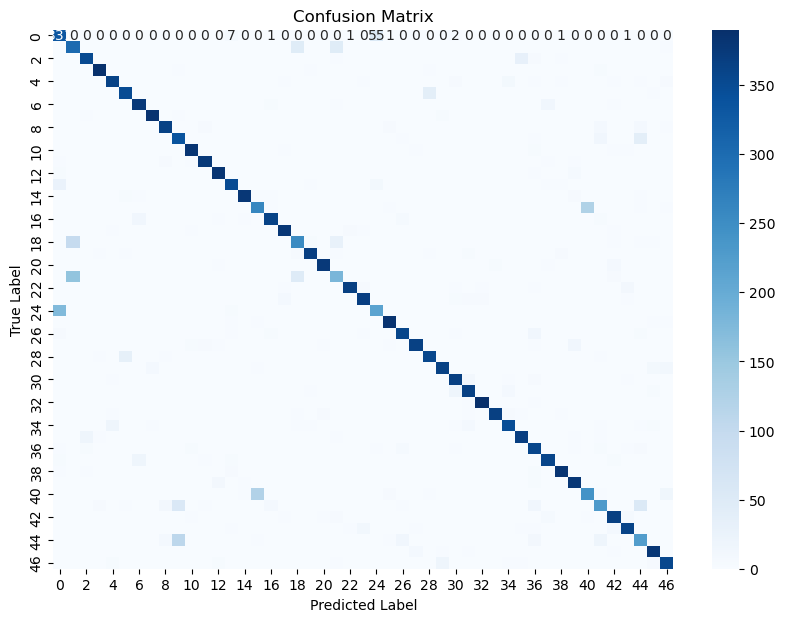

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.83      0.69       400
           1       0.54      0.76      0.63       400
           2       0.91      0.88      0.90       400
           3       0.95      0.97      0.96       400
           4       0.91      0.91      0.91       400
           5       0.87      0.87      0.87       400
           6       0.91      0.94      0.92       400
           7       0.96      0.96      0.96       400
           8       0.91      0.91      0.91       400
           9       0.65      0.84      0.74       400
          10       0.95      0.95      0.95       400
          11       0.94      0.94      0.94       400
          12       0.94      0.95      0.95       400
          13       0.91      0.87      0.89       400
          14       0.97      0.94      0.96       400
          15       0.66      0.65      0.65       400
          16       0.94      0.91      0.92       400
    

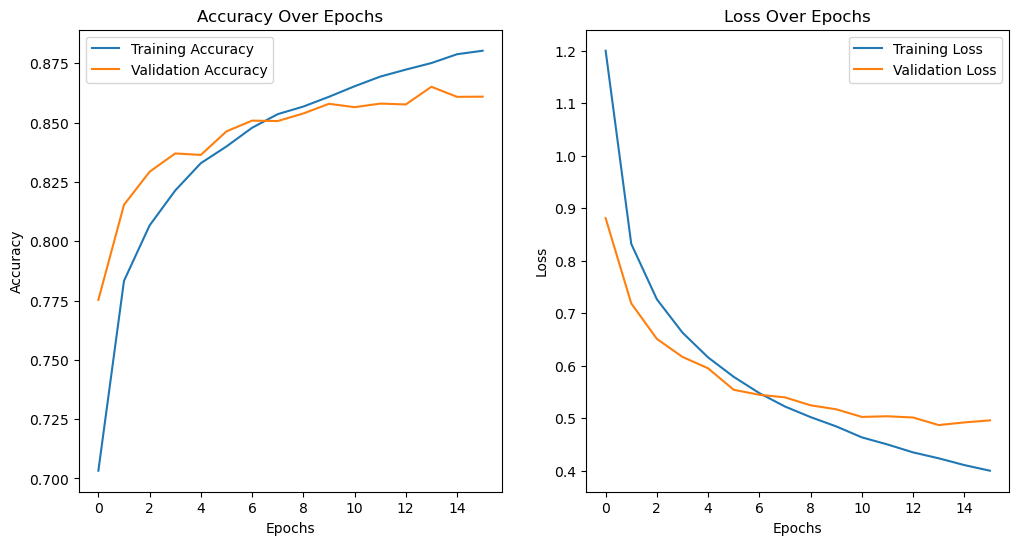

In [27]:
evaluate_model(final_model, X_test_corrected, y_test, history=final_model_history)

1/1 [==============================] - 0s 21ms/step


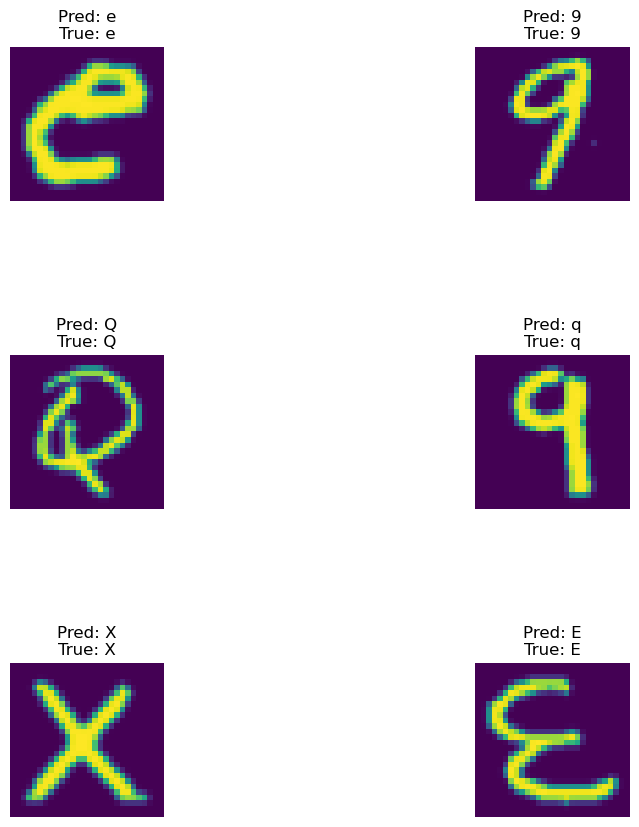

In [31]:
# Checking how the model performed on the test data.
visualize_and_predict_top_samples(final_model, X_test_corrected, y_test, mapping_df=mapping, num_samples=6)

## CNN

### Defining a baseline model:
#### We first start off by defining a baseline model with the minimum requrement of 2 convolutional layers. The model creation function is used which was previously defined, making this process clean and easily understandable. This time the shape of the features data had to be reshaped to (28, 28, 1) so it could then be passed throught he convolutional layers. The model is trained for 10 epochs with a batch size of 32. The accuracy and loss curves show a lot of overfitting in this model.
#### Baseline Accuracy: 86.02%%

In [99]:
# Reshape from (784,) to (28, 28, 1)
X_train_cnn = X_train.reshape((-1, 28, 28, 1))
X_test_cnn = X_test_corrected.reshape((-1, 28, 28, 1))
X_val_cnn = X_val.reshape((-1, 28, 28, 1))

In [86]:
input_shape = X_train_cnn[0].shape
num_classes = len(unique_labels)

In [93]:
configs = [
    {'type': 'conv2d', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'input_shape': input_shape},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'conv2d', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same'},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 128, 'activation': 'relu'}
]

baseline_model_cnn = create_cnn_model(configs,
                                      optimizer='adam', 
                                      loss='sparse_categorical_crossentropy', 
                                      input_shape=input_shape, 
                                      num_classes=num_classes, 
                                      output_activation='softmax')

In [94]:
baseline_model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

In [96]:
baseline_model_cnn_history, baseline_model_cnn_time = train_model(baseline_model_cnn, X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val))

Epoch 1/10
3173/3173 [==============================] - 24s 5ms/step - loss: 0.6822 - accuracy: 0.7860 - val_loss: 0.4526 - val_accuracy: 0.8465
Epoch 2/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.3970 - accuracy: 0.8618 - val_loss: 0.3979 - val_accuracy: 0.8543
Epoch 3/10
3173/3173 [==============================] - 14s 5ms/step - loss: 0.3346 - accuracy: 0.8800 - val_loss: 0.3543 - val_accuracy: 0.8715
Epoch 4/10
3173/3173 [==============================] - 15s 5ms/step - loss: 0.2925 - accuracy: 0.8923 - val_loss: 0.3524 - val_accuracy: 0.8777
Epoch 5/10
3173/3173 [==============================] - 14s 5ms/step - loss: 0.2595 - accuracy: 0.9016 - val_loss: 0.3566 - val_accuracy: 0.8722
Epoch 6/10
3173/3173 [==============================] - 14s 5ms/step - loss: 0.2324 - accuracy: 0.9097 - val_loss: 0.3591 - val_accuracy: 0.8785
Epoch 7/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.2098 - accuracy: 0.9168 - val_loss: 0.3722 - val_ac

588/588 [==============================] - 1s 2ms/step
Accuracy: 86.02%


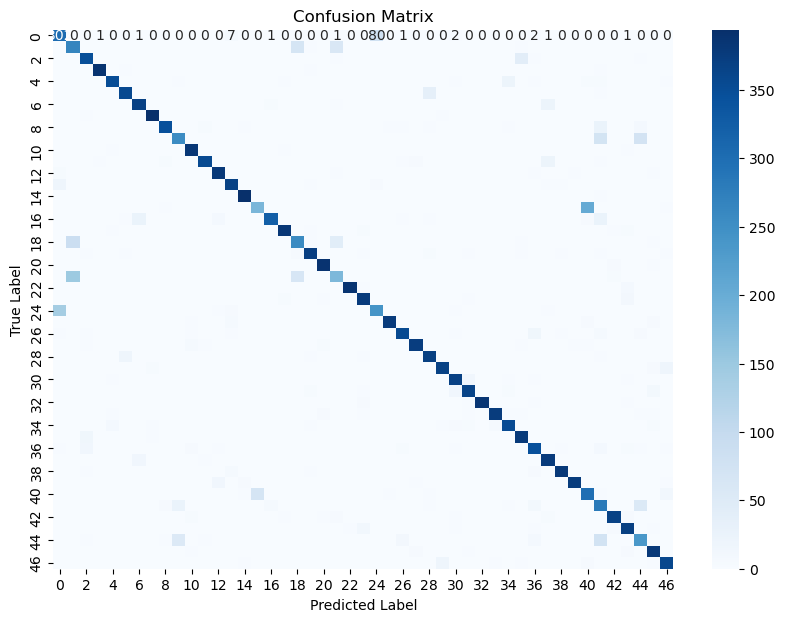

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.76      0.69       400
           1       0.52      0.66      0.58       400
           2       0.87      0.87      0.87       400
           3       0.98      0.97      0.97       400
           4       0.95      0.88      0.91       400
           5       0.93      0.89      0.91       400
           6       0.89      0.92      0.90       400
           7       0.97      0.98      0.97       400
           8       0.95      0.86      0.90       400
           9       0.75      0.64      0.69       400
          10       0.93      0.96      0.95       400
          11       0.96      0.89      0.92       400
          12       0.92      0.95      0.93       400
          13       0.92      0.92      0.92       400
          14       0.96      0.98      0.97       400
          15       0.71      0.46      0.56       400
          16       0.96      0.81      0.88       400
    

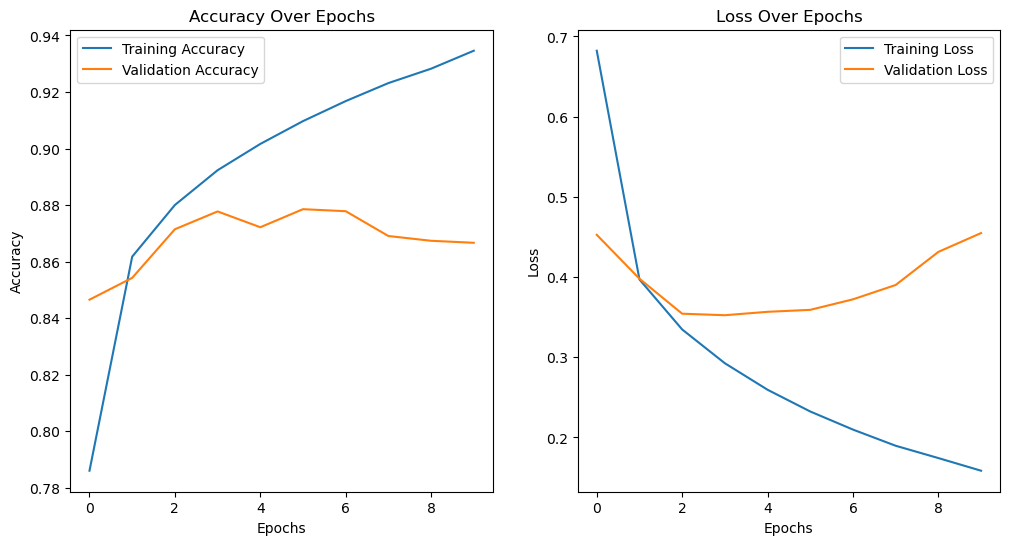

In [98]:
evaluate_model(baseline_model_cnn, X_test_cnn, y_test, history=baseline_model_cnn_history)

### Model 2 - Optimizer search:
#### In the second model, we move on to using the baseline configuration of the model and finding the most suitable optimizer by using the random search algorithm of the Keras Tuner.
#### Optimizers searched: Adam, SGD, RMSprop
#### Best optimizer: Adam

In [100]:
configs = [
    {'type': 'conv2d', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'input_shape': input_shape},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'conv2d', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same'},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 128, 'activation': 'relu'}
]

def build_model(hp):
    # Testing between three optimizers
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    
    model_2_cnn = create_cnn_model(configs,
                                      optimizer=optimizer, 
                                      loss='sparse_categorical_crossentropy', 
                                      input_shape=input_shape, 
                                      num_classes=num_classes, 
                                      output_activation='softmax')
    return model_2_cnn

In [101]:
model_2_cnn = run_hyperparameter_tuning('random', build_model, X_train_cnn, y_train, X_val_cnn, y_val, 
                                    objective='val_accuracy', max_trials=5, max_epochs=5, directory='tuner', project_name='optimizer_cnn')

Trial 3 Complete [00h 01m 27s]
val_accuracy: 0.8754432797431946

Best val_accuracy So Far: 0.8782801628112793
Total elapsed time: 00h 03m 49s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)        

### Model 3 - Learning rate search:
#### In the third model, we move on to using the baseline configurations along with the best found optimizer from the previous step. We find the most suitable learning rate using the Bayesian algorithm of the Keras Tuner.
#### Range of learning rates searched: [0.00001, 1]
#### Best learning rate: 0.001

In [102]:
configs = [
    {'type': 'conv2d', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'input_shape': input_shape},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'conv2d', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same'},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 128, 'activation': 'relu'}
]

def build_model(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1, step=10, sampling="log")
    
    model_3_cnn = create_cnn_model(configs,
                                   optimizer='adam', 
                                   loss='sparse_categorical_crossentropy', 
                                   input_shape=input_shape, 
                                   num_classes=num_classes, 
                                   output_activation='softmax',
                                   learning_rate=learning_rate)
    return model_3_cnn

In [103]:
model_3_cnn = run_hyperparameter_tuning('bayesian', build_model, X_train_cnn, y_train, X_val_cnn, y_val, 
                                    objective='val_accuracy', max_trials=5, max_epochs=5, directory='tuner', project_name='learning_rate_cnn')

Trial 5 Complete [00h 01m 13s]
val_accuracy: 0.7866134643554688

Best val_accuracy So Far: 0.8725177049636841
Total elapsed time: 00h 06m 03s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)        

### Model 4 - Learning rate scheduling (Exponential Decay):
#### We now test out 2 different learning rate schedulers. In this first test we use the Exponential decay which uses the initial learning rate as the best one found in the previous step. It then decays every 10000 samples with a decay rate of 0.9 which was found to be the best after researching and trying out different values.

In [107]:
configs = [
    {'type': 'conv2d', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'input_shape': input_shape},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'conv2d', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same'},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 128, 'activation': 'relu'}
]

exp_dcy = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, 
                                                      decay_steps=10000, 
                                                      decay_rate=0.9)
model_4_cnn = create_cnn_model(configs,
                               optimizer='adam', 
                               loss='sparse_categorical_crossentropy', 
                               input_shape=input_shape, 
                               num_classes=num_classes, 
                               output_activation='softmax',
                               learning_rate=exp_dcy)

In [108]:
model_4_cnn_history, model_4_cnn_time = train_model(model_4_cnn, X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val))

Epoch 1/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.6686 - accuracy: 0.7883 - val_loss: 0.4269 - val_accuracy: 0.8548
Epoch 2/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.3945 - accuracy: 0.8630 - val_loss: 0.3751 - val_accuracy: 0.8701
Epoch 3/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.3325 - accuracy: 0.8803 - val_loss: 0.3668 - val_accuracy: 0.8705
Epoch 4/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.2920 - accuracy: 0.8916 - val_loss: 0.3504 - val_accuracy: 0.8766
Epoch 5/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.2593 - accuracy: 0.9022 - val_loss: 0.3642 - val_accuracy: 0.8739
Epoch 6/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.2308 - accuracy: 0.9106 - val_loss: 0.3669 - val_accuracy: 0.8754
Epoch 7/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.2080 - accuracy: 0.9170 - val_loss: 0.3891 - val_ac

### Model 5 - Learning rate scheduling (Inverse Time Decay):
#### In this second test we use the INverse Time decay which uses the initial learning rate as the best one found in the previous step. It then decays every 10000 samples with a decay rate of 0.9 which was found to be the best after researching and trying out different values. This was found to be the best performing scheduler as it produces a higher accuracy.

In [113]:
configs = [
    {'type': 'conv2d', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'input_shape': input_shape},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'conv2d', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same'},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 128, 'activation': 'relu'}
]

inv_dcy = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, 
                                                      decay_steps=10000, 
                                                      decay_rate=0.9)
model_5_cnn = create_cnn_model(configs,
                               optimizer='adam', 
                               loss='sparse_categorical_crossentropy', 
                               input_shape=input_shape, 
                               num_classes=num_classes, 
                               output_activation='softmax',
                               learning_rate=inv_dcy)

In [114]:
model_5_cnn_history, model_5_cnn_time = train_model(model_5_cnn, X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val))

Epoch 1/10
3173/3173 [==============================] - 15s 4ms/step - loss: 0.6560 - accuracy: 0.7920 - val_loss: 0.4573 - val_accuracy: 0.8406
Epoch 2/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.3884 - accuracy: 0.8637 - val_loss: 0.3710 - val_accuracy: 0.8660
Epoch 3/10
3173/3173 [==============================] - 14s 5ms/step - loss: 0.3289 - accuracy: 0.8806 - val_loss: 0.3523 - val_accuracy: 0.8749
Epoch 4/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.2870 - accuracy: 0.8930 - val_loss: 0.3527 - val_accuracy: 0.8740
Epoch 5/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.2541 - accuracy: 0.9037 - val_loss: 0.3622 - val_accuracy: 0.8754
Epoch 6/10
3173/3173 [==============================] - 14s 4ms/step - loss: 0.2249 - accuracy: 0.9118 - val_loss: 0.3658 - val_accuracy: 0.8693
Epoch 7/10
3173/3173 [==============================] - 14s 5ms/step - loss: 0.2013 - accuracy: 0.9195 - val_loss: 0.3789 - val_ac

### Model 6 - Layers/nodes:
#### Moving on to finding the ideal number of layers and nodes per layer, We built a function for the Keras Tuner passing hp as the parameter. The function loops through adding 2 - 4 blocks of colvolutional layers and the number of filters in each of these layers between 16 and 128 with a step size of 16. The number of dense layers and its nodes is also found out right after the colvolutional blocks. these are searched between 1 - 3 layers having 32 - 512 nodesin each with a step of 32. This can be changed to look for more layers, nodes and more filters, but would be computationally expensive. Using the Bayesian algorithm for this helps as it uses the Gaussian process which is more efficient than random search as it looks for new itteration around the best performing combination.

In [117]:
def build_model(hp):
        # Ensures that we start with a clean slate by clearing any residual model data from previous sessions.
        tf.keras.backend.clear_session()

        # Initialize the model as a sequential one, which means the layers are arranged in a sequential order.
        model = keras.Sequential()

        # Dynamically testing between adding the number of conv2d + maxpooling blocks
        for i in range(hp.Int('num_conv_blocks', 2, 4, default=2)):
            # Ensures the input_shape is added only to the first Conv2D layer.
            if i == 0:
                model.add(keras.layers.Conv2D(
                    filters=hp.Int('filters_' + str(i), 16, 128, step=16),
                    kernel_size=(3, 3),
                    activation='relu',
                    padding='same',
                    input_shape=input_shape
                ))
            else:
                model.add(keras.layers.Conv2D(
                    filters=hp.Int('filters_' + str(i), 16, 128, step=16),
                    kernel_size=(3, 3),
                    activation='relu',
                    padding='same'
                ))
            # Adding the pool layer after every conv2d layer.
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

        # Flattening the data outputted from the conv layers to be fed into the dense layer.
        model.add(keras.layers.Flatten())

        # Tuning the number of dense layers and their units
        for i in range(hp.Int('num_dense_layers', 1, 3, default=1)):
            model.add(keras.layers.Dense(
                units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                activation='relu'
            ))

        # Add the output layer with the number of classes and softmax activation function.
        model.add(keras.layers.Dense(num_classes, activation='softmax'))

        # Compiling the model with the Adam optimizer, loss function, and accuracy as the evaluation metric.
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=inv_dcy),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [118]:
model_6_cnn = run_hyperparameter_tuning('bayesian', build_model, X_train_cnn, y_train, X_val_cnn, y_val, 
                                    objective='val_accuracy', max_trials=20, max_epochs=5, directory='tuner', project_name='layers_nodes_cnn')

Trial 20 Complete [00h 01m 20s]
val_accuracy: 0.8759751915931702

Best val_accuracy So Far: 0.8809397220611572
Total elapsed time: 00h 29m 06s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 48)        480       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 112)       48496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 112)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)       

### Model 7 - Activation function:
#### We now find the best activation function using the previously found best number of layers, filters and nodes.
#### Activation functions searched: relu, elu, leaky relu
#### Best activation function: relu

In [119]:
def build_model(hp):
    # Testing between three activation functions
    activation=hp.Choice('activation', values=['relu', 'elu', 'leaky_relu'])

    configs = [
    {'type': 'conv2d', 'filters': 48, 'kernel_size': (3, 3), 'activation': activation, 'padding': 'same', 'input_shape': input_shape},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'conv2d', 'filters': 112, 'kernel_size': (3, 3), 'activation': activation, 'padding': 'same'},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 416, 'activation': activation}]
    
    model_7_cnn = create_cnn_model(configs,
                                   optimizer='adam', 
                                   loss='sparse_categorical_crossentropy', 
                                   input_shape=input_shape, 
                                   num_classes=num_classes, 
                                   output_activation='softmax',
                                   learning_rate=inv_dcy)
    return model_7_cnn

In [120]:
model_7_cnn = run_hyperparameter_tuning('random', build_model, X_train_cnn, y_train, X_val_cnn, y_val, 
                                    objective='val_accuracy', max_trials=5, max_epochs=5, directory='tuner', project_name='activation_cnn')

Trial 3 Complete [00h 01m 15s]
val_accuracy: 0.8777482509613037

Best val_accuracy So Far: 0.8781028389930725
Total elapsed time: 00h 03m 46s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 48)        480       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 112)       48496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 112)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)        

### Model 8 - Batch normalization:
#### We test for each combination of adding a batch normalization layer in the model configs. This process is done by again defining the build model function for the kears tuner. and using the boolean function of deciding when to activate the batch norm layer between previously defind layers in the configs list.

In [132]:
def build_model(hp):
    model = keras.Sequential()

    configs = [
    {'type': 'conv2d', 'filters': 48, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'input_shape': input_shape},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'conv2d', 'filters': 112, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same'},
    {'type': 'maxpool', 'pool_size': (2, 2)},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 416, 'activation': 'relu'}]

    # Iterate over the provided layer configurations and add layers and configs of the layer accordingly.
    for i, config in enumerate(configs):
        if config['type'] == 'conv2d':
        # Ensures the input_shape is added only to the first Conv2D layer.
            if i == 0:
                model.add(keras.layers.Conv2D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config['activation'],
                    padding=config['padding'],
                    input_shape=config['input_shape']
                ))
            else:
                model.add(keras.layers.Conv2D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config['activation'],
                    padding=config['padding']
                ))

            # Dynamically decide to add a Batch Normalization layer based on tuner's decision.
            if hp.Boolean(f'batch_norm_{i}'):
                model.add(keras.layers.BatchNormalization())

        elif config['type'] == 'maxpool':
            model.add(keras.layers.MaxPooling2D(pool_size=config['pool_size']))
            
            # Dynamically decide to add a Batch Normalization layer based on tuner's decision.
            if hp.Boolean(f'batch_norm_{i}'):
                model.add(keras.layers.BatchNormalization())

        elif config['type'] == 'flatten':
            model.add(keras.layers.Flatten())

        elif config['type'] == 'dense':
            model.add(keras.layers.Dense(
                units=config['nodes'],
                activation=config['activation']
            ))

            # Dynamically decide to add a Batch Normalization layer based on tuner's decision.
            if hp.Boolean(f'batch_norm_dense_{i}'):
                model.add(keras.layers.BatchNormalization())

    # Add the output layer with the number of classes and softmax activation function.
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    # Compiling the model with the Adam optimizer, loss function, and accuracy as the evaluation metric.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=inv_dcy),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [133]:
model_8_cnn = run_hyperparameter_tuning('bayesian', build_model, X_train_cnn, y_train, X_val_cnn, y_val, 
                                    objective='val_accuracy', max_trials=20, max_epochs=5, directory='tuner', project_name='batch_norm_cnn')

Trial 20 Complete [00h 01m 37s]
val_accuracy: 0.8807623982429504

Best val_accuracy So Far: 0.8843971490859985
Total elapsed time: 00h 31m 42s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 48)        480       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 48)       192       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 48)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 48)       192       
 hNormalization)                                                 
                         

### Model 9 - Regularization:
#### This process involves the use of the Bayesian algorithm for searching through the the layers activating each type of regularization and search for their regularization value in the range of 0.0001 to 0.1 using the log sampling. The function helps with the creation of the model based on the given list of configs. The search found out that having no regularization in any layer gave the highest accuracy.

In [137]:
def build_model(hp):
    model = keras.Sequential()

    configs = [
    {'type': 'conv2d', 'filters': 48, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'input_shape': input_shape, 'batch_normalization': True},
    {'type': 'maxpool', 'pool_size': (2, 2), 'batch_normalization': True},
    {'type': 'conv2d', 'filters': 112, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'batch_normalization': True},
    {'type': 'maxpool', 'pool_size': (2, 2), 'batch_normalization': True},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 416, 'activation': 'relu', 'batch_normalization': True}]

    # Iterate over the provided layer configurations provided in the configs.
    for i, config in enumerate(configs):
        # Defaults no regularizer.
        reg = None  
        # Adds regularization only to the layers which support it.
        if config['type'] in ['conv2d', 'dense']:
            # Define regularization if the layer type supports it.
            reg_type = hp.Choice(f'reg_type_layer_{i}', ['l1', 'l2', 'none'])
            if reg_type != 'none':
                l1_l2_value = hp.Float(f'reg_value_layer_{i}', min_value=0.0001, max_value=0.01, step=10, sampling='log')
                if reg_type == 'l1':
                    reg = keras.regularizers.L1(l1_l2_value)
                elif reg_type == 'l2':
                    reg = keras.regularizers.L2(l1_l2_value)
                    
        if config['type'] == 'conv2d':
        # Ensures the input_shape is added only to the first Conv2D layer.
            if i == 0:
                model.add(keras.layers.Conv2D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config['activation'],
                    padding=config['padding'],
                    kernel_regularizer=reg,
                    input_shape=config['input_shape']
                ))
            else:
                model.add(keras.layers.Conv2D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config['activation'],
                    padding=config['padding'],
                    kernel_regularizer=reg,
                ))

            # Add batch normalization layer if given in the list of configs.
            if config.get('batch_normalization', False):
                model.add(keras.layers.BatchNormalization())

        elif config['type'] == 'maxpool':
            model.add(keras.layers.MaxPooling2D(pool_size=config['pool_size']))
            
            # Add batch normalization layer if given in the list of configs.
            if config.get('batch_normalization', False):
                model.add(keras.layers.BatchNormalization())

        elif config['type'] == 'flatten':
            model.add(keras.layers.Flatten())

        elif config['type'] == 'dense':
            model.add(keras.layers.Dense(
                units=config['nodes'],
                activation=config['activation'],
                kernel_regularizer=reg,
            ))

            # Add batch normalization layer if given in the list of configs.
            if config.get('batch_normalization', False):
                model.add(keras.layers.BatchNormalization())

    # Add the output layer with the number of classes and softmax activation function.
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    # Compiling the model with the Adam optimizer, loss function, and accuracy as the evaluation metric.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=inv_dcy),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [136]:
model_9_cnn = run_hyperparameter_tuning('bayesian', build_model, X_train_cnn, y_train, X_val_cnn, y_val, 
                                    objective='val_accuracy', max_trials=20, max_epochs=5, directory='tuner', project_name='regularization_cnn')

Trial 20 Complete [00h 01m 49s]
val_accuracy: 0.8846631050109863

Best val_accuracy So Far: 0.8861702084541321
Total elapsed time: 00h 36m 45s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 48)        480       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 48)       192       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 48)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 48)       192       
 hNormalization)                                                 
                         

### Model 10 - Dropout:
#### In the same way as before, we built a function to pass to the Keras Tuner, but this time we check for the application of a dropout layer inbetween each layer. The droupout rate is also checked between the range 0.1 to 0.5. Running the Bayesian algorithm proves most effective in situations where the complexity is high as it uses probabilty distrubution to search for different values around the current best performing value.

In [140]:
def build_model(hp):
    model = keras.Sequential()

    configs = [
    {'type': 'conv2d', 'filters': 48, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'input_shape': input_shape, 'batch_normalization': True},
    {'type': 'maxpool', 'pool_size': (2, 2), 'batch_normalization': True},
    {'type': 'conv2d', 'filters': 112, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'batch_normalization': True},
    {'type': 'maxpool', 'pool_size': (2, 2), 'batch_normalization': True},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 416, 'activation': 'relu', 'batch_normalization': True}]

    # Iterate over the provided layer configurations in the configs list.
    for i, config in enumerate(configs):
        if config['type'] == 'conv2d':
        # Ensures the input_shape is added only to the first Conv2D layer.
            if i == 0:
                model.add(keras.layers.Conv2D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config['activation'],
                    padding=config['padding'],
                    input_shape=config['input_shape']
                ))
            else:
                model.add(keras.layers.Conv2D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config['activation'],
                    padding=config['padding']
                ))

             # Add batch normalization layer if given in the list of configs.
            if config.get('batch_normalization', False):
                model.add(keras.layers.BatchNormalization())

            # Optionally add Dropout layer based on the tuners decision.
            include_dropout = hp.Boolean(f'include_dropout_{i}')
            if include_dropout:
                # setting the dropout rates based on the tuners decision.
                dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
                model.add(keras.layers.Dropout(dropout_rate))

        elif config['type'] == 'maxpool':
            model.add(keras.layers.MaxPooling2D(pool_size=config['pool_size']))
            
            if config.get('batch_normalization', False):
                model.add(keras.layers.BatchNormalization())

            # Optionally add Dropout layer.
            include_dropout = hp.Boolean(f'include_dropout_{i}')
            if include_dropout:
                dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
                model.add(keras.layers.Dropout(dropout_rate))

        elif config['type'] == 'flatten':
            model.add(keras.layers.Flatten())

        elif config['type'] == 'dense':
            model.add(keras.layers.Dense(
                units=config['nodes'],
                activation=config['activation']
            ))

            # Batch Normalization for dense layer if specified.
            if config.get('batch_normalization', False):
                model.add(keras.layers.BatchNormalization())

            # Optionally add Dropout layer.
            include_dropout = hp.Boolean(f'include_dropout_{i}')
            if include_dropout:
                dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
                model.add(keras.layers.Dropout(dropout_rate))

    # Add the output layer with the number of classes and softmax activation function.
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    # Compiling the model with the Adam optimizer, loss function, and accuracy as the evaluation metric.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=inv_dcy),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [141]:
model_10_cnn = run_hyperparameter_tuning('bayesian', build_model, X_train_cnn, y_train, X_val_cnn, y_val, 
                                    objective='val_accuracy', max_trials=20, max_epochs=5, directory='tuner', project_name='dropout_cnn')

Trial 20 Complete [00h 01m 53s]
val_accuracy: 0.8816489577293396

Best val_accuracy So Far: 0.8871454000473022
Total elapsed time: 00h 37m 24s
Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 48)        480       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 48)       192       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 48)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 48)       192       
 hNormalization)                                                 
                         

### Final CNN model:
#### This final model uses the previously explored knowledge and best combination of hyperparameters into one. Further tweaking of hyperparameters is done to overcome overfitting. The use of early stopping helps prevent this. Val loss is monitored with a patience of 2 i.e. the model will stop training if there is no improvment in performance after 2 consecutive epochs. The top 6 images from the test set are visualized using the function and their true and predicted labels are shown.
#### Final model accuracy: 86.89%

In [170]:
configs = [
    {'type': 'conv2d', 'filters': 48, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'input_shape': input_shape, 'batch_normalization': True},
    {'type': 'maxpool', 'pool_size': (2, 2), 'batch_normalization': True},
    {'type': 'conv2d', 'filters': 112, 'kernel_size': (3, 3), 'activation': 'relu', 'padding': 'same', 'batch_normalization': True, 'dropout': 0.4},
    {'type': 'maxpool', 'pool_size': (2, 2), 'batch_normalization': True, 'l1': 0.001},
    {'type': 'flatten'},
    {'type': 'dense', 'nodes': 416, 'activation': 'relu', 'batch_normalization': True, 'l1': 0.001}
]

final_model_cnn = create_cnn_model(configs,
                               optimizer='adam', 
                               loss='sparse_categorical_crossentropy', 
                               input_shape=input_shape, 
                               num_classes=num_classes, 
                               output_activation='softmax',
                               learning_rate=inv_dcy)


In [171]:
final_model_cnn_history, final_model_cnn_time = train_model(final_model_cnn, X_train_cnn, y_train, epochs=25, batch_size=32, validation_data=(X_val_cnn, y_val),
                                                           early_stopping=True, es_monitor='val_loss', es_patience=2, verbose=1)

Epoch 1/25
3173/3173 [==============================] - 22s 7ms/step - loss: 4.3987 - accuracy: 0.7481 - val_loss: 1.8839 - val_accuracy: 0.8243
Epoch 2/25
3173/3173 [==============================] - 21s 7ms/step - loss: 1.5855 - accuracy: 0.8279 - val_loss: 1.3493 - val_accuracy: 0.8517
Epoch 3/25
3173/3173 [==============================] - 21s 7ms/step - loss: 1.2895 - accuracy: 0.8424 - val_loss: 1.2068 - val_accuracy: 0.8479
Epoch 4/25
3173/3173 [==============================] - 21s 7ms/step - loss: 1.1387 - accuracy: 0.8497 - val_loss: 1.0588 - val_accuracy: 0.8624
Epoch 5/25
3173/3173 [==============================] - 21s 7ms/step - loss: 1.0356 - accuracy: 0.8547 - val_loss: 1.0694 - val_accuracy: 0.8372
Epoch 6/25
3173/3173 [==============================] - 21s 7ms/step - loss: 0.9777 - accuracy: 0.8605 - val_loss: 0.9382 - val_accuracy: 0.8638
Epoch 7/25
3173/3173 [==============================] - 21s 7ms/step - loss: 0.9125 - accuracy: 0.8627 - val_loss: 0.9105 - val_ac

588/588 [==============================] - 1s 2ms/step
Accuracy: 86.89%


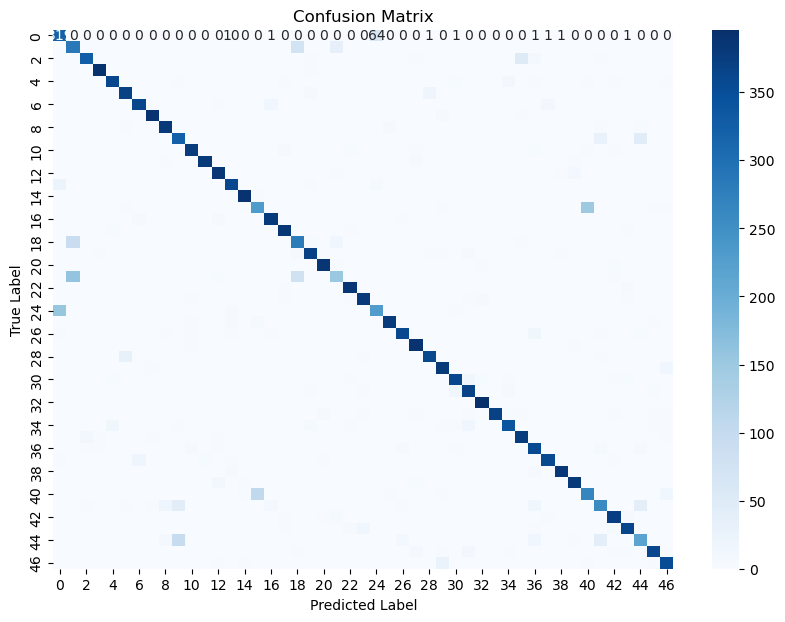

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       400
           1       0.53      0.71      0.61       400
           2       0.94      0.81      0.87       400
           3       0.97      0.98      0.98       400
           4       0.91      0.90      0.91       400
           5       0.88      0.93      0.90       400
           6       0.93      0.91      0.92       400
           7       0.97      0.97      0.97       400
           8       0.92      0.95      0.93       400
           9       0.68      0.81      0.74       400
          10       0.96      0.94      0.95       400
          11       0.98      0.95      0.97       400
          12       0.92      0.96      0.94       400
          13       0.91      0.90      0.90       400
          14       0.97      0.97      0.97       400
          15       0.66      0.58      0.62       400
          16       0.92      0.94      0.93       400
    

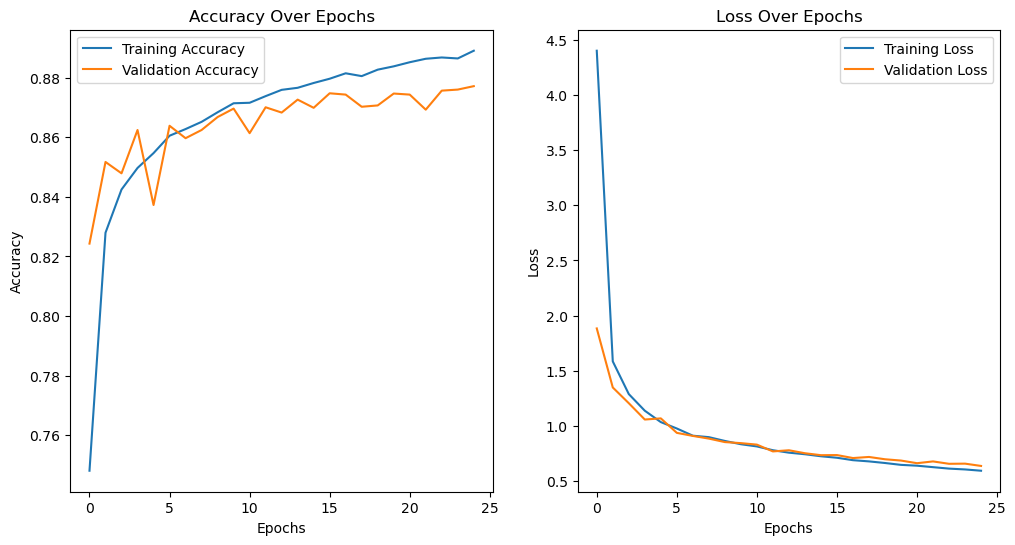

In [172]:
evaluate_model(final_model_cnn, X_test_cnn, y_test, history=final_model_cnn_history)

1/1 [==============================] - 0s 229ms/step


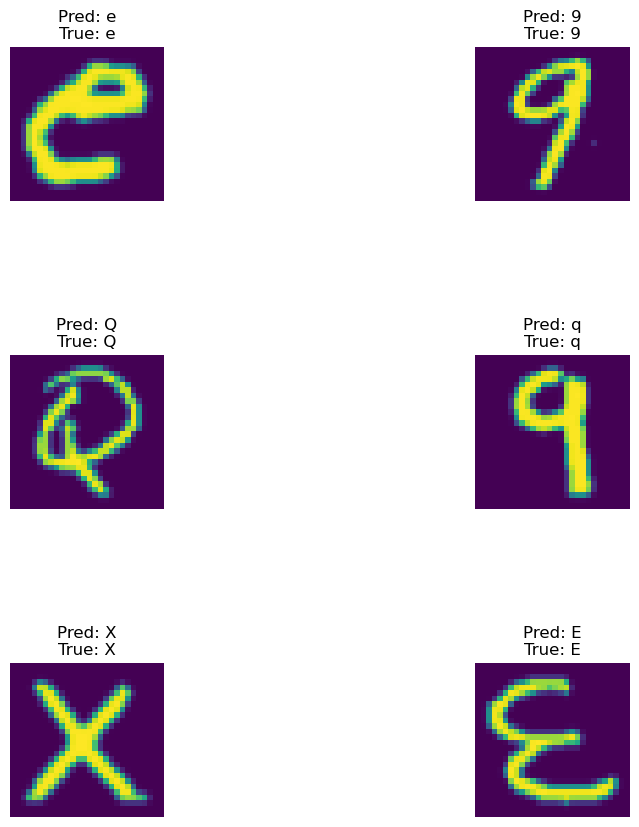

In [173]:
visualize_and_predict_top_samples(final_model_cnn, X_test_cnn, y_test, mapping_df=mapping, num_samples=6)